# <font size=5> <strong>Heart Disease Prediction
 

## 1. Importing Libraries

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import torch

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.metrics import(accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
                            auc, confusion_matrix, classification_report, make_scorer)

# Modeling – XGBoost and TabNet
import xgboost as xgb
from xgboost import XGBClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

# Hyperparameter optimization
import optuna
from sklearn.model_selection import GridSearchCV

# Explainability
import shap
import random
import os

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
import keras_tuner as kt
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K

In [2]:
import numpy as np
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

## 2. Data Preprocessing

### Importing datasets

In [71]:
df_A = pd.read_csv("Cleveland+Hungary+VA_long_beach+Switzerland.csv") # Source domain = multi-hospital dataset
df_B = pd.read_csv("Heart_disease_cleveland.csv")                     # Target domain = original Cleveland dataset

### Exploring and Inspecting Data sets

In [4]:
df_A.info() # Displays concise summary of DataFrame A: index range, column names, non-null counts, and data types.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 919 entries, 0 to 918
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        919 non-null    int64  
 1   age       919 non-null    int64  
 2   sex       919 non-null    object 
 3   dataset   919 non-null    object 
 4   cp        919 non-null    object 
 5   trestbps  919 non-null    float64
 6   chol      919 non-null    float64
 7   fbs       919 non-null    bool   
 8   restecg   919 non-null    object 
 9   thalch    919 non-null    float64
 10  exang     919 non-null    bool   
 11  oldpeak   919 non-null    float64
 12  slope     919 non-null    object 
 13  ca        919 non-null    float64
 14  thal      919 non-null    object 
 15  num       919 non-null    int64  
dtypes: bool(2), float64(5), int64(3), object(6)
memory usage: 102.4+ KB


In [5]:
df_B.info() # Displays concise summary of DataFrame B: index range, column names, non-null counts, and data types.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
# Remove Cleveland data from df_A before pretraining
df_A = df_A[df_A['dataset'] != 'Cleveland']

In [7]:
print(df_A.columns) # Prints the list of column names in DataFrame A.
print(df_B.columns) # Prints the list of column names in DataFrame B.

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


In [8]:
df_A = df_A.rename(columns={'thalch': 'thalach','num': 'target'}) #Rename columns in Dataset A to match Dataset B.

In [9]:
df_A = df_A.drop(columns=['id', 'dataset']) #Drop irrelevant columns in Dataset A (id, dataset).

In [10]:
# Convert target column in Dataset A to binary (0=no disease, 1=disease)
df_A['target'] = df_A['target'].apply(lambda x: 1 if x > 0 else 0)

In [11]:
# Map all categorical strings/booleans in Dataset A to numeric codes matching the target domain.
sex_map = {'Male': 1, 'Female': 0}

cp_map = {
    'typical angina': 0,
    'atypical angina': 1,
    'non-anginal': 2,
    'asymptomatic': 3
}

fbs_map = {True: 1, False: 0}

restecg_map = {
    'normal': 0,
    'st-t abnormality': 1,
    'lv hypertrophy': 2
}

exang_map = {True: 1, False: 0}

slope_map = {
    'upsloping': 0,
    'flat': 1,
    'downsloping': 2
}

thal_map = {
    'normal': 1,
    'fixed defect': 2,
    'reversable defect': 3
}

In [12]:
# Align features so both datasets have identical column names and encodings.
df_A['sex'] = df_A['sex'].map(sex_map)
df_A['cp'] = df_A['cp'].map(cp_map)
df_A['fbs'] = df_A['fbs'].map(fbs_map)
df_A['restecg'] = df_A['restecg'].map(restecg_map)
df_A['exang'] = df_A['exang'].map(exang_map)
df_A['slope'] = df_A['slope'].map(slope_map)
df_A['thal'] = df_A['thal'].map(thal_map)

In [13]:
# Final Check (Both should return zero missing values.)
print(df_A.isnull().sum())
print(df_B.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [14]:
#Do a final check for the target domain to ensure all columns are non-null.
df_A.info()

<class 'pandas.core.frame.DataFrame'>
Index: 615 entries, 304 to 918
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       615 non-null    int64  
 1   sex       615 non-null    int64  
 2   cp        615 non-null    int64  
 3   trestbps  615 non-null    float64
 4   chol      615 non-null    float64
 5   fbs       615 non-null    int64  
 6   restecg   615 non-null    int64  
 7   thalach   615 non-null    float64
 8   exang     615 non-null    int64  
 9   oldpeak   615 non-null    float64
 10  slope     615 non-null    int64  
 11  ca        615 non-null    float64
 12  thal      615 non-null    int64  
 13  target    615 non-null    int64  
dtypes: float64(5), int64(9)
memory usage: 72.1 KB


In [15]:
#Do a final check for the source domain to ensure all columns are non-null. 
df_B.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [16]:
BOLD = '\033[1m'
END = '\033[0m'

print(f"{BOLD}Datasets after preprocessing:{END}")

print(f"{BOLD}Multi-hospital Dataset:{END}")
print(f"{BOLD}{df_A.head(3).T.to_string(line_width=1000)}{END}")

print(f"\n{BOLD}Cleveland Dataset:{END}")
print(f"{BOLD}{df_B.head(3).T.to_string(line_width=1000)}{END}")

Datasets after preprocessing:
Multi-hospital Dataset:
            304     305    306
age        29.0   29.00   30.0
sex         1.0    1.00    0.0
cp          1.0    1.00    0.0
trestbps  120.0  140.00  170.0
chol      243.0  240.48  237.0
fbs         0.0    0.00    0.0
restecg     0.0    0.00    1.0
thalach   160.0  170.00  170.0
exang       0.0    0.00    0.0
oldpeak     0.0    0.00    0.0
slope       0.0    0.00    0.0
ca          0.0    0.00    0.0
thal        1.0    1.00    2.0
target      0.0    0.00    0.0

Cleveland Dataset:
              0      1      2
age        63.0   67.0   67.0
sex         1.0    1.0    1.0
cp          0.0    3.0    3.0
trestbps  145.0  160.0  120.0
chol      233.0  286.0  229.0
fbs         1.0    0.0    0.0
restecg     2.0    2.0    2.0
thalach   150.0  108.0  129.0
exang       0.0    1.0    1.0
oldpeak     2.3    1.5    2.6
slope       2.0    1.0    1.0
ca          0.0    3.0    2.0
thal        2.0    1.0    3.0
target      0.0    1.0    1.0


## 3. Data split

In [17]:
X_pretrain = df_A.drop('target', axis=1) 
y_pretrain = df_A['target']               

# Split the source domain into 80% train and 20% temp (for val+test)
X_pretrain_train, X_pretrain_temp, y_pretrain_train, y_pretrain_temp = train_test_split(
    X_pretrain, y_pretrain,
    test_size=0.2,          # 20% goes to temp (val+test)
    random_state=42,
    stratify=y_pretrain
)

# Split temp into 50% validation and 50% test → each 10% of total
X_pretrain_val, X_pretrain_test, y_pretrain_val, y_pretrain_test = train_test_split(
    X_pretrain_temp, y_pretrain_temp,
    test_size=0.5,          # half of temp = 10% of total
    random_state=42,
    stratify=y_pretrain_temp
)

# Target domain: Cleveland dataset for FINE-TUNING and evaluation
X_finetune = df_B.drop('target', axis=1)
y_finetune = df_B['target']


# Split target domain into 80% train and 20% temp (for val+test)
X_finetune_train, X_finetune_temp, y_finetune_train, y_finetune_temp = train_test_split(
    X_finetune, y_finetune,
    test_size=0.2,          # 20% goes to temp (val+test) 
    random_state=42,        # reproducible splits
    stratify=y_finetune     # preserve class distribution
)

# Split temp into 50% validation and 50% test → each 10% of total
X_finetune_val, X_finetune_test, y_finetune_val, y_finetune_test = train_test_split(
    X_finetune_temp, y_finetune_temp,
    test_size=0.5,          # 20% of training data will be used as the validation set
    random_state=42,        # reproducible splits
    stratify=y_finetune_temp  # preserve class distribution
)

## 4. Feature selection(Only to training subset)

What to Look For:

Similar Feature Correlations: If the correlations between the target variable and the features are similar in both datasets, that suggests that the features carry similar predictive power in both datasets. This means that the pre-trained model could transfer knowledge effectively to the Cleveland dataset during fine-tuning.

Discrepant Feature Correlations: If the correlations are significantly different between the two datasets, it may indicate that the relationship between the features and the target is dataset-specific, which could make transfer learning less effective. For example, a feature with a strong correlation with the target in Dataset A but weak or no correlation in Dataset B may not transfer well.

In [18]:
# Combine resampled training features and target
df_pretrain_fs = X_pretrain_train.copy()
df_pretrain_fs["target"] = y_pretrain_train.values

# Correlation with target (absolute value)
corr_A = (df_pretrain_fs.corr()["target"].drop("target").abs().sort_values(ascending=False))

print("Correlation (Source domain – training only):")
print(corr_A)

df_finetune_fs = X_finetune_train.copy()
df_finetune_fs["target"] = y_finetune_train.values

corr_B = (df_finetune_fs.corr()["target"].drop("target").abs().sort_values(ascending=False))

print("Correlation (Target domain – training only):")
print(corr_B)

Correlation (Source domain – training only):
cp          0.507301
ca          0.498332
exang       0.463155
slope       0.453537
thal        0.446200
oldpeak     0.377454
thalach     0.368993
age         0.348638
sex         0.320523
chol        0.268397
fbs         0.154707
trestbps    0.147888
restecg     0.045622
Name: target, dtype: float64
Correlation (Target domain – training only):
thal        0.541295
ca          0.447965
exang       0.420280
thalach     0.409475
cp          0.400620
oldpeak     0.392151
slope       0.323349
sex         0.308342
age         0.209664
restecg     0.160363
trestbps    0.136085
chol        0.077191
fbs         0.045889
Name: target, dtype: float64


In [19]:
# Compute *signed* correlations
corr_A = (df_pretrain_fs.corr()["target"].drop("target").abs().sort_values(ascending=False))
corr_B = (df_finetune_fs.corr()["target"].drop("target").abs().sort_values(ascending=False))


corr_diff_threshold = 0.1
high_corr_threshold = 0.3

similar_features = []

# Consistency across domains
for feature in corr_A.index:
    if feature in corr_B.index:
        diff = abs(corr_A[feature] - corr_B[feature])
        if diff < corr_diff_threshold:
            similar_features.append(feature)

# Strong predictors in either domain
for feature in set(corr_A.index).union(corr_B.index):
    if feature in corr_A.index and abs(corr_A[feature]) >= high_corr_threshold:
        similar_features.append(feature)
    if feature in corr_B.index and abs(corr_B[feature]) >= high_corr_threshold:
        similar_features.append(feature)

similar_features = list(set(similar_features))

print("Selected features (training-only):", similar_features)

Selected features (training-only): ['trestbps', 'sex', 'exang', 'slope', 'cp', 'age', 'thalach', 'ca', 'oldpeak', 'thal']


In [20]:
# Apply feature mask to all datasets

# Source domain
X_pretrain_train = X_pretrain_train[similar_features]
X_pretrain_val   = X_pretrain_val[similar_features]
X_pretrain_test  = X_pretrain_test[similar_features]

# Target domain
X_finetune_train = X_finetune_train[similar_features]
X_finetune_val   = X_finetune_val[similar_features]
X_finetune_test  = X_finetune_test[similar_features]

In [21]:
print("Source train features:", X_pretrain_train.columns.tolist())
print("Source val features:  ", X_pretrain_val.columns.tolist())
print("Source test features: ", X_pretrain_test.columns.tolist())

print("Target train features:", X_finetune_train.columns.tolist())
print("Target val features:  ", X_finetune_val.columns.tolist())
print("Target test features: ", X_finetune_test.columns.tolist())


Source train features: ['trestbps', 'sex', 'exang', 'slope', 'cp', 'age', 'thalach', 'ca', 'oldpeak', 'thal']
Source val features:   ['trestbps', 'sex', 'exang', 'slope', 'cp', 'age', 'thalach', 'ca', 'oldpeak', 'thal']
Source test features:  ['trestbps', 'sex', 'exang', 'slope', 'cp', 'age', 'thalach', 'ca', 'oldpeak', 'thal']
Target train features: ['trestbps', 'sex', 'exang', 'slope', 'cp', 'age', 'thalach', 'ca', 'oldpeak', 'thal']
Target val features:   ['trestbps', 'sex', 'exang', 'slope', 'cp', 'age', 'thalach', 'ca', 'oldpeak', 'thal']
Target test features:  ['trestbps', 'sex', 'exang', 'slope', 'cp', 'age', 'thalach', 'ca', 'oldpeak', 'thal']


In [22]:
print("Source train shape:", X_pretrain_train.shape)
print("Source val shape:  ", X_pretrain_val.shape)
print("Source test shape: ", X_pretrain_test.shape)

print("Target train shape:", X_finetune_train.shape)
print("Target val shape:  ", X_finetune_val.shape)
print("Target test shape: ", X_finetune_test.shape)

Source train shape: (492, 10)
Source val shape:   (61, 10)
Source test shape:  (62, 10)
Target train shape: (242, 10)
Target val shape:   (30, 10)
Target test shape:  (31, 10)


## 5. Class imbalance handling using SMOTE

In [23]:
# Apply SMOTE to source domain data (X_pretrain_train, y_pretrain_train)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_pretrain_train_res, y_pretrain_train_res = smote.fit_resample(X_pretrain_train, y_pretrain_train)

# Apply SMOTE to target domain data (X_finetune_train, y_finetune_train)
X_finetune_train_res, y_finetune_train_res = smote.fit_resample(X_finetune_train, y_finetune_train)

# Check the resampled data shapes and class distributions
print(f"Resampled Dataset A training data shape: {X_pretrain_train_res.shape}")
print(f"Resampled Dataset B training data shape: {X_finetune_train_res.shape}")

# Optionally, you can print the class distribution before and after SMOTE
print(f"Class distribution before SMOTE (Source domain): \n{y_pretrain_train.value_counts()}")
print(f"Class distribution after SMOTE (Source domain): \n{y_pretrain_train_res.value_counts()}")

print(f"Class distribution before SMOTE (Target domain): \n{y_finetune_train.value_counts()}")
print(f"Class distribution after SMOTE (Target domain): \n{y_finetune_train_res.value_counts()}")


Resampled Dataset A training data shape: (590, 10)
Resampled Dataset B training data shape: (262, 10)
Class distribution before SMOTE (Source domain): 
target
1    295
0    197
Name: count, dtype: int64
Class distribution after SMOTE (Source domain): 
target
1    295
0    295
Name: count, dtype: int64
Class distribution before SMOTE (Target domain): 
target
0    131
1    111
Name: count, dtype: int64
Class distribution after SMOTE (Target domain): 
target
1    131
0    131
Name: count, dtype: int64


## 6. XGBoost

### Pretraining on the source domain

#### Hyperparameter tuning for Pre-training

In [23]:
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5],
}

# Create XGBoost with balanced class weight
xgb_pretrain_base = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=1,                 # single-threaded = deterministic
    scale_pos_weight=1
)

grid_search = GridSearchCV(
    estimator=xgb_pretrain_base,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=1,                 # ALSO single-threaded
    verbose=2
)

grid_search.fit(
    X_pretrain_train_res,
    y_pretrain_train_res,
    eval_set=[(X_pretrain_val, y_pretrain_val)],
    verbose=False
)

# Use best estimator 
xgb_pretrain_best = grid_search.best_estimator_

Fitting 5 folds for each of 13824 candidates, totalling 69120 fits


In [24]:
print(f"\nBest parameters for pretraining: {grid_search.best_params_}")
print(f"Best F1-score: {grid_search.best_score_:.4f}")

# UPDATED
# Best parameters for pretraining: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100,
#                                   'reg_alpha': 0, 'reg_lambda': 0.5, 'subsample': 0.8}
# Best F1-score: 0.8994


Best parameters for pretraining: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'subsample': 0.7}
Best F1-score: 0.8965


#### Pre-training on the source domain

In [24]:
# Define the best parameters found during the Grid Search for pretraining on Dataset A......DO NOT RUN THIS CODE IF YOU DO HYPERPARAMETER TUNING
best_pretrain_params = {
    'colsample_bytree': 0.7,
    'learning_rate': 0.01,
    'max_depth': 8,
    'n_estimators': 300,
    'reg_alpha': 0.1, 
    'reg_lambda': 0.5, 
    'subsample': 1.0
}

In [25]:
# Get the best parameters....UNCOMMENT THE LINE BELOW IF YOU DO HYPERPARAMETER TUNING
# best_pretrain_params = grid_search.best_params_

for param, value in best_pretrain_params.items():
    print(f"  {param}: {value}")

# Create and train fresh model
xgb_pretrain = xgb.XGBClassifier(
    **best_pretrain_params,
    eval_metric='logloss',
    random_state=42,   
    early_stopping_rounds=50,
    n_jobs=1             
)

xgb_pretrain.fit(
    X_pretrain_train_res,
    y_pretrain_train_res,
    eval_set=[(X_pretrain_val, y_pretrain_val)],
    verbose=1
)

  colsample_bytree: 0.7
  learning_rate: 0.01
  max_depth: 8
  n_estimators: 300
  reg_alpha: 0.1
  reg_lambda: 0.5
  subsample: 1.0
[0]	validation_0-logloss:0.68962
[1]	validation_0-logloss:0.68509
[2]	validation_0-logloss:0.68114
[3]	validation_0-logloss:0.67682
[4]	validation_0-logloss:0.67239
[5]	validation_0-logloss:0.66902
[6]	validation_0-logloss:0.66489
[7]	validation_0-logloss:0.66074
[8]	validation_0-logloss:0.65727
[9]	validation_0-logloss:0.65349
[10]	validation_0-logloss:0.64910
[11]	validation_0-logloss:0.64457
[12]	validation_0-logloss:0.64099
[13]	validation_0-logloss:0.63783
[14]	validation_0-logloss:0.63401
[15]	validation_0-logloss:0.63069
[16]	validation_0-logloss:0.62735
[17]	validation_0-logloss:0.62396
[18]	validation_0-logloss:0.62049
[19]	validation_0-logloss:0.61672
[20]	validation_0-logloss:0.61361
[21]	validation_0-logloss:0.61123
[22]	validation_0-logloss:0.60757
[23]	validation_0-logloss:0.60468
[24]	validation_0-logloss:0.60166
[25]	validation_0-logloss:0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=1,
              num_parallel_tree=None, ...)

In [26]:
# PRETRAINED MODEL EVALUATION ON A-TEST
Dataset_A_Pretrain = xgb_pretrain.predict(X_pretrain_test)

#Calculate and print metrics on source domain's test set
Dataset_A_Pretrain_acc = accuracy_score(y_pretrain_test, Dataset_A_Pretrain) * 100
Dataset_A_Pretrain_f1  = f1_score(y_pretrain_test, Dataset_A_Pretrain) * 100

cm_A = confusion_matrix(y_pretrain_test, Dataset_A_Pretrain)
TN_A, FP_A, FN_A, TP_A = cm_A.ravel()


recall_A = TP_A / (TP_A + FN_A) * 100
specificity_A = TN_A / (TN_A + FP_A) * 100
print(f"Pretraining Test Accuracy on Source domain: {Dataset_A_Pretrain_acc:.2f}%")
print(f"Pretraining Test F1 on Source domain: {Dataset_A_Pretrain_f1:.2f}%")
print(f"Pretraining Test Recall (Sensitivity) on Source domain: {recall_A:.2f}%")
print(f"Pretraining Test Specificity on Source domain: {specificity_A:.2f}%")

Pretraining Test Accuracy on Source domain: 85.48%
Pretraining Test F1 on Source domain: 88.31%
Pretraining Test Recall (Sensitivity) on Source domain: 91.89%
Pretraining Test Specificity on Source domain: 76.00%


In [27]:
Dataset_B_Pretrain = xgb_pretrain.predict(X_finetune_test)

#Calculate and print metrics on target domain's test set
Dataset_B_Pretrain_acc = accuracy_score(y_finetune_test, Dataset_B_Pretrain) * 100
Dataset_B_Pretrain_f1 = f1_score(y_finetune_test, Dataset_B_Pretrain) * 100
cm_B = confusion_matrix(y_finetune_test, Dataset_B_Pretrain)
TN_B, FP_B, FN_B, TP_B = cm_B.ravel()
recall_B = TP_B / (TP_B + FN_B) * 100
specificity_B = TN_B / (TN_B + FP_B) * 100

print(f"Pretraining Accuracy on target domain's test Set: {Dataset_B_Pretrain_acc:.2f}%")
print(f"Pretraining F1 on target domain's test Set: {Dataset_B_Pretrain_f1:.2f}%")
print(f"Pretraining Recall (Sensitivity) on target domain's test Set: {recall_B:.2f}%")
print(f"Pretraining Specificity on target domain's test Set: {specificity_B:.2f}%")

Pretraining Accuracy on target domain's test Set: 74.19%
Pretraining F1 on target domain's test Set: 75.00%
Pretraining Recall (Sensitivity) on target domain's test Set: 85.71%
Pretraining Specificity on target domain's test Set: 64.71%


### Finetuning on the target domain

#### Hyperparameter tuning for Fine-tuning

In [28]:
param_grid_finetune = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.001, 0.01, 0.05],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1, 1.5],
}

xgb_finetune_best = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=1,
    scale_pos_weight=1
)

grid_search_finetune = GridSearchCV(
    estimator=xgb_finetune_best,
    param_grid=param_grid_finetune,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=1
)

grid_search_finetune.fit(
    X_finetune_train_res,
    y_finetune_train_res,
    eval_set=[(X_finetune_val, y_finetune_val)],
    xgb_model=xgb_pretrain.get_booster(),
    verbose=False
)

xgb_finetune_best = grid_search_finetune.best_estimator_

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


In [29]:
print(f"\nBest parameters for finetuning: {grid_search_finetune.best_params_}")
print(f"Best F1-score: {grid_search_finetune.best_score_:.4f}")

# Best parameters for finetuning: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 4, 
#                                  'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.5, 'subsample': 0.7}
# Best F1-score: 0.8231


Best parameters for finetuning: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.7}
Best F1-score: 0.8216


#### Finetuning on the target domain

In [28]:
# #DO NOT THE LINE CODE BELOW IF YOU DO HYPERPARAMETER TUNING
best_finetune_params = {
    'colsample_bytree': 0.7,
    'learning_rate': 0.009,
    'max_depth': 6,
    'n_estimators': 300,
    'reg_alpha': 0.1, 
    'reg_lambda': 1.5, 
    'subsample': 1.0
}

In [29]:
# Get the best parameters from fine-tuning grid search......UNCOMMENT THE LINE BELOW IF YOU DO HYPERPARAMETER TUNING
# best_finetune_params = grid_search_finetune.best_params_

for param, value in best_finetune_params.items():
    print(f"  {param}: {value}")

xgb_finetune = xgb.XGBClassifier(
    **best_finetune_params,
    eval_metric='logloss',
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=1
)

xgb_finetune.fit(
    X_finetune_train_res,
    y_finetune_train_res, 
    eval_set=[(X_finetune_val, y_finetune_val)], 
    xgb_model=xgb_pretrain.get_booster(),
    verbose=1 
)

  colsample_bytree: 0.7
  learning_rate: 0.009
  max_depth: 6
  n_estimators: 300
  reg_alpha: 0.1
  reg_lambda: 1.5
  subsample: 1.0
[0]	validation_0-logloss:0.31364
[1]	validation_0-logloss:0.31171
[2]	validation_0-logloss:0.31046
[3]	validation_0-logloss:0.30874
[4]	validation_0-logloss:0.30726
[5]	validation_0-logloss:0.30543
[6]	validation_0-logloss:0.30367
[7]	validation_0-logloss:0.30296
[8]	validation_0-logloss:0.30126
[9]	validation_0-logloss:0.30033
[10]	validation_0-logloss:0.29865
[11]	validation_0-logloss:0.29749
[12]	validation_0-logloss:0.29669
[13]	validation_0-logloss:0.29564
[14]	validation_0-logloss:0.29440
[15]	validation_0-logloss:0.29289
[16]	validation_0-logloss:0.29135
[17]	validation_0-logloss:0.29038
[18]	validation_0-logloss:0.28935
[19]	validation_0-logloss:0.28867
[20]	validation_0-logloss:0.28775
[21]	validation_0-logloss:0.28648
[22]	validation_0-logloss:0.28564
[23]	validation_0-logloss:0.28466
[24]	validation_0-logloss:0.28360
[25]	validation_0-logloss:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.009, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=1,
              num_parallel_tree=None, ...)

In [30]:
# FINE-TUNED MODEL EVALUATION ON A-TEST (Checking for Catastrophic Forgetting)
Dataset_A_Finetune = xgb_finetune.predict(X_pretrain_test) # Using the fine-tuned model on A's test set

# Calculate and print metrics on source domain's test set
acc_A_Finetune = accuracy_score(y_pretrain_test, Dataset_A_Finetune) * 100
f1_A_Finetune = f1_score(y_pretrain_test, Dataset_A_Finetune) * 100

cm_A_Finetune = confusion_matrix(y_pretrain_test, Dataset_A_Finetune)
TN_A_F, FP_A_F, FN_A_F, TP_A_F = cm_A_Finetune.ravel()

recall_A_Finetune = TP_A_F / (TP_A_F + FN_A_F) * 100
specificity_A_Finetune = TN_A_F / (TN_A_F + FP_A_F) * 100

print(f"Fine-Tuning Test Accuracy on Source domain: {acc_A_Finetune:.2f}%")
print(f"Fine-Tuning Test F1 on Source domain: {f1_A_Finetune:.2f}%")
print(f"Fine-Tuning Test Recall (Sensitivity) on Source domain: {recall_A_Finetune:.2f}%")
print(f"Fine-Tuning Test Specificity on Source domain: {specificity_A_Finetune:.2f}%")

Fine-Tuning Test Accuracy on Source domain: 80.65%
Fine-Tuning Test F1 on Source domain: 84.62%
Fine-Tuning Test Recall (Sensitivity) on Source domain: 89.19%
Fine-Tuning Test Specificity on Source domain: 68.00%


In [31]:
# FINE-TUNED MODEL EVALUATION ON B-TEST (Final Transfer Learning Performance)
Dataset_B_Finetune = xgb_finetune.predict(X_finetune_test) # Using the fine-tuned model on B's test set

# Calculate and print metrics on target domain's test set
acc_B_Finetune = accuracy_score(y_finetune_test, Dataset_B_Finetune) * 100
f1_B_Finetune = f1_score(y_finetune_test, Dataset_B_Finetune) * 100

cm_B_Finetune = confusion_matrix(y_finetune_test, Dataset_B_Finetune)
TN_B_F, FP_B_F, FN_B_F, TP_B_F = cm_B_Finetune.ravel()

recall_B_Finetune = TP_B_F / (TP_B_F + FN_B_F) * 100
specificity_B_Finetune = TN_B_F / (TN_B_F + FP_B_F) * 100
roc_auc_B_Finetune = roc_auc_score(y_finetune_test, Dataset_B_Finetune) * 100

print(f"Fine-Tuning Test ROC-AUC on Target domain (B): {roc_auc_B_Finetune:.2f}%")
print(f"Fine-Tuning Test Accuracy on Target domain (B): {acc_B_Finetune:.2f}%")
print(f"Fine-Tuning Test F1 on Target domain (B): {f1_B_Finetune:.2f}%")
print(f"Fine-Tuning Test Recall (Sensitivity) on Target domain (B): {recall_B_Finetune:.2f}%")
print(f"Fine-Tuning Test Specificity on Target domain (B): {specificity_B_Finetune:.2f}%")

Fine-Tuning Test ROC-AUC on Target domain (B): 85.29%
Fine-Tuning Test Accuracy on Target domain (B): 83.87%
Fine-Tuning Test F1 on Target domain (B): 84.85%
Fine-Tuning Test Recall (Sensitivity) on Target domain (B): 100.00%
Fine-Tuning Test Specificity on Target domain (B): 70.59%


### SHAP figure from the proposed model

C:\Users\prosp\AppData\Local\Temp\ipykernel_19640\923481824.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_finetune_test,


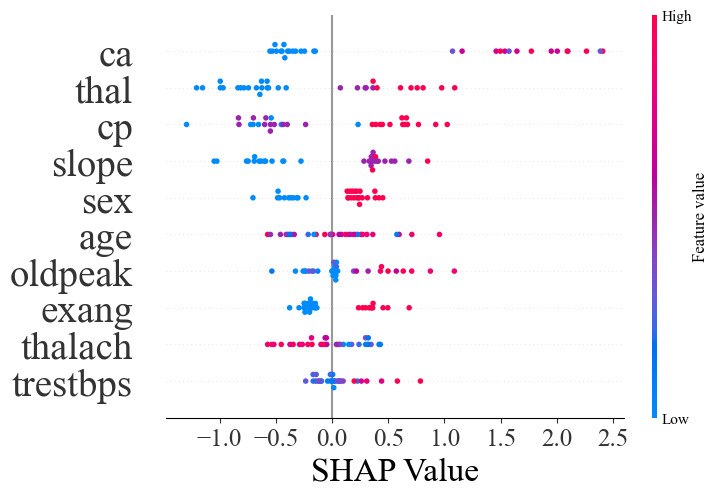

In [32]:
# Set global font to Times New Roman
plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 24})  # Set global font size

# Create SHAP explainer for XGBoost model
explainer = shap.TreeExplainer(xgb_finetune)

# Calculate SHAP values
shap_values = explainer(X_finetune_test)

# Create a larger figure
plt.figure(figsize=(14, 8))

# Generate summary plot with custom settings, no caption
shap.summary_plot(shap_values, X_finetune_test, 
                  max_display=20,  # Show top 20 features
                  show=False)

# # Customize the plot 
# plt.gcf().axes[-1].set_aspect(200) 
# plt.gcf().axes[-1].set_box_aspect(100)


# Customize title, axis labels, and ticks
# plt.title('SHAP Summary Plot (XGBoost)', fontsize=20, fontweight='bold')  # Title font size
plt.xlabel('SHAP Value', fontsize=24)  # X-axis font size
plt.ylabel('', fontsize=26)  # Y-axis font size

# Increase font size for tick labels
plt.xticks(fontsize=18)  # X-axis tick font size
plt.yticks(fontsize=28)  # Y-axis tick font size


plt.tight_layout()  # Adjust the layout to prevent clipping

# Save the plot as an image with high resolution and no caption
plt.savefig('shap_summary_xgboost.png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()

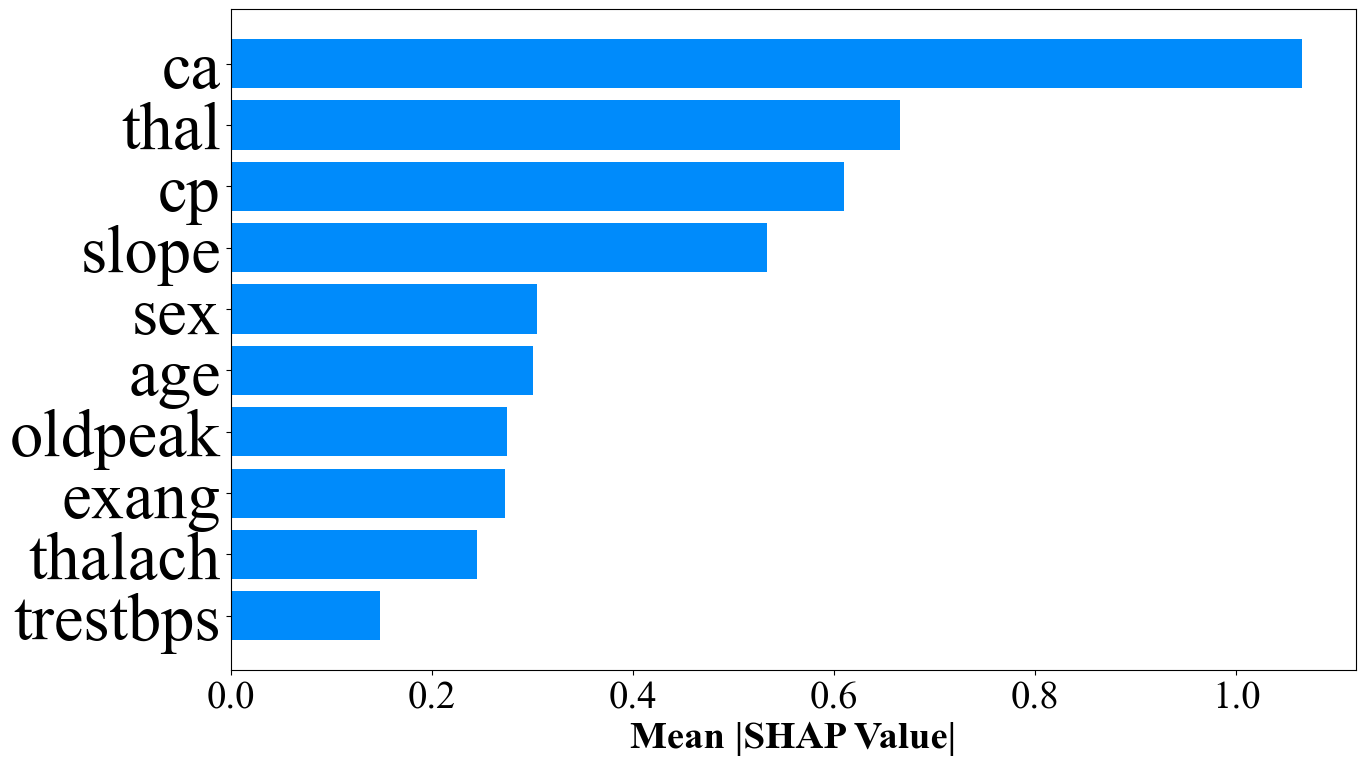

In [185]:
plt.rcParams.update({'font.family': 'Times New Roman'})

# Access the SHAP values (they are in shap_values_xgb.values)
shap_values_abs_xgb = np.abs(shap_values.values)  # Take absolute values of SHAP values

# Calculate the mean SHAP value for each feature
mean_shap_values_xgb = np.mean(shap_values_abs_xgb, axis=0)  # Mean across all samples for each feature

# Create a DataFrame to store feature importance
feature_importance_xgb_df = pd.DataFrame({
    'Feature': X_finetune_test.columns,  # feature names
    'Mean SHAP Value': mean_shap_values_xgb
})

# Sort the DataFrame by the importance of features (descending order)
feature_importance_xgb_df = feature_importance_xgb_df.sort_values(by='Mean SHAP Value', ascending=False)

# Plot feature importance
plt.figure(figsize=(14, 8))
plt.barh(feature_importance_xgb_df['Feature'], feature_importance_xgb_df['Mean SHAP Value'], color='#008bfb')
plt.xlabel('Mean |SHAP Value|', fontsize =28,fontweight='bold')
# Increase font size for tick labels
plt.xticks(fontsize=28, fontweight='normal')   # X-axis tick font size
plt.yticks(fontsize=48, fontweight='normal')  # Y-axis tick font size
# plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
plt.tight_layout()  # Adjust the layout to prevent clipping
# Save the plot as an image with high resolution and no caption
plt.savefig('shap_feature_importance_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

### Confusion matrix and ROC-AUC curve for the proposed model

In [38]:
# Set global font to Times New Roman
# plt.rcParams.update({'font.family': 'Times New Roman'})
plt.rcParams.update({'font.family': 'Times New Roman', 'font.weight': 'bold', 'font.size' : '16'})

# Assuming y_finetune_test and Dataset_B_Finetune are already defined
cm = confusion_matrix(y_finetune_test, Dataset_B_Finetune)

# Unravel the confusion matrix to get TN, FP, FN, TP
tn, fp, fn, tp = cm.ravel()

plt.figure(figsize=(5, 4))
im = plt.imshow(cm, cmap='Blues', interpolation='nearest') 

vmax = cm.max()
colorbar_ticks = np.arange(0, vmax + 10, 10)
plt.colorbar(im, ticks=colorbar_ticks)

# plt.title('Confusion Matrix of the fine-tuned model')

ax = plt.gca()
# ax.invert_yaxis()  # You can uncomment this if you want to invert the Y-axis

# Set X-axis labels (Predicted: Disease then No Disease)
plt.xticks([0, 1], ['No Disease', 'Disease']) 
plt.yticks([0, 1], ['No Disease', 'Disease']) 

plt.ylabel('Actual')
plt.xlabel('Predicted')

# Dynamic text color for contrast
norm = mcolors.Normalize(vmin=cm.min(), vmax=cm.max())
cmap = plt.colormaps['Blues']

for i in range(2):
    for j in range(2):
        cell_value = cm[i, j]
        cell_color = cmap(norm(cell_value))
        luminance = 0.299 * cell_color[0] + 0.587 * cell_color[1] + 0.114 * cell_color[2]
        text_color = 'white' if luminance < 0.5 else 'black'
        
        # Set the text in Times New Roman
        plt.text(j, i, f'{cell_value}', ha='center', va='center', color=text_color, fontsize=24, fontweight='bold')

# Save the confusion matrix image
plt.savefig('confusion_matrix_xgboost.png', dpi=300, bbox_inches='tight')
plt.close()


In [39]:
plt.rcParams.update({'font.family': 'Times New Roman', 'font.weight': 'bold', 'font.size' : '16'})

# Calculate Precision, Recall, F1-Score
precision = precision_score(y_finetune_test, Dataset_B_Finetune) * 100
recall = recall_score(y_finetune_test, Dataset_B_Finetune) * 100
f1 = f1_score(y_finetune_test, Dataset_B_Finetune) * 100

# Calculate Specificity: TN / (TN + FP)
specificity = (tn / (tn + fp)) * 100

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_finetune_test, Dataset_B_Finetune) * 100

print(f"ROC-AUC: {roc_auc:.2f}%")

# Plot ROC curve with blue tones (IEEE standard)
fpr, tpr, _ = roc_curve(y_finetune_test, Dataset_B_Finetune)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(7, 6))

# Plot the ROC curve: Use 'orange' color and update the label
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', lw=2, linestyle='--')

# Set limits and labels as in the original image
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') # Changed back to match the image axis label

# Adjust legend location to match the original image
plt.legend(loc='lower right')

# Save the ROC curve image (you can keep your original filename or update it)
plt.savefig('roc_curve_xgboost.png', dpi=300, bbox_inches='tight')
plt.close()

ROC-AUC: 82.35%


### XGBoost with no Transfer Learning

In [34]:
baseline_model = XGBClassifier(
    n_estimators=300,            
    max_depth=6,
    learning_rate=0.009,
    subsample=1.0,
    colsample_bytree=0.7,
    eval_metric='logloss',
    reg_lambda = 1.5,
    reg_alpha = 0.1,
    early_stopping_rounds=50,
    random_state=42,
    n_jobs=1
)

baseline_model.fit(
    X_finetune_train_res,
    y_finetune_train_res,
    eval_set=[(X_finetune_val, y_finetune_val)]
)

[0]	validation_0-logloss:0.68921
[1]	validation_0-logloss:0.68507
[2]	validation_0-logloss:0.68126
[3]	validation_0-logloss:0.67732
[4]	validation_0-logloss:0.67260
[5]	validation_0-logloss:0.66873
[6]	validation_0-logloss:0.66405
[7]	validation_0-logloss:0.65966
[8]	validation_0-logloss:0.65562
[9]	validation_0-logloss:0.65204
[10]	validation_0-logloss:0.64815
[11]	validation_0-logloss:0.64398
[12]	validation_0-logloss:0.64027
[13]	validation_0-logloss:0.63645
[14]	validation_0-logloss:0.63237
[15]	validation_0-logloss:0.62943
[16]	validation_0-logloss:0.62584
[17]	validation_0-logloss:0.62310
[18]	validation_0-logloss:0.61913
[19]	validation_0-logloss:0.61560
[20]	validation_0-logloss:0.61218
[21]	validation_0-logloss:0.60934
[22]	validation_0-logloss:0.60605
[23]	validation_0-logloss:0.60343
[24]	validation_0-logloss:0.60043
[25]	validation_0-logloss:0.59687
[26]	validation_0-logloss:0.59372
[27]	validation_0-logloss:0.59036
[28]	validation_0-logloss:0.58756
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.009, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=1,
              num_parallel_tree=None, ...)

In [35]:
# Evaluate on Dataset B test set
y_pred_baseline = baseline_model.predict(X_finetune_test)

baseline_acc = accuracy_score(y_finetune_test, y_pred_baseline) * 100
baseline_f1  = f1_score(y_finetune_test, y_pred_baseline) * 100

cm = confusion_matrix(y_finetune_test, y_pred_baseline)
TN, FP, FN, TP = cm.ravel()

recall_score_calc = TP / (TP + FN) * 100
specificity_score_calc = TN / (TN + FP) * 100


print(f"Baseline Accuracy (Dataset B): {baseline_acc:.2f}%")
print(f"Baseline F1-score (Dataset B): {baseline_f1:.2f}%")
print(f"Baseline Recall (Sensitivity): {recall_score_calc:.2f}%")
print(f"Baseline Specificity: {specificity_score_calc:.2f}%")

Baseline Accuracy (Dataset B): 83.87%
Baseline F1-score (Dataset B): 83.87%
Baseline Recall (Sensitivity): 92.86%
Baseline Specificity: 76.47%


## 7. Tabnet

In [36]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [37]:
# Defining the training, validation, and test datasets for the source domain
X_A_train = X_pretrain_train_res.values  # Features for training on the source domain (pre-training phase)
y_A_train = y_pretrain_train_res.values  # Target labels for training on the source domain

X_A_val   = X_pretrain_val.values  # Features for validation on the source domain
y_A_val   = y_pretrain_val.values  # Target labels for validation on the source domain

X_A_test  = X_pretrain_test.values  # Features for testing on the source domain
y_A_test  = y_pretrain_test.values  # Target labels for testing on the source domain

# Defining the training, validation, and test datasets for the target domain
X_B_train = X_finetune_train_res.values  # Features for training on the target domain (fine-tuning phase)
y_B_train = y_finetune_train_res.values  # Target labels for training on the target domain

X_B_val   = X_finetune_val.values  # Features for validation on the target domain
y_B_val   = y_finetune_val.values  # Target labels for validation on the target domain

X_B_test  = X_finetune_test.values  # Features for testing on the target domain
y_B_test  = y_finetune_test.values  # Target labels for testing on the target domain

In [38]:
scaler = StandardScaler()

X_A_train = scaler.fit_transform(X_A_train).astype(np.float32)  # Fit scaler on source train set, transform it
X_A_val = scaler.transform(X_A_val).astype(np.float32)          # Transform source validation set
X_A_test = scaler.transform(X_A_test).astype(np.float32)        # Transform source test set

y_A_train = y_A_train.astype(np.int64)  # Convert source train labels to int64
y_A_val = y_A_val.astype(np.int64)      # Convert source validation labels
y_A_test = y_A_test.astype(np.int64)    # Convert source test labels

X_B_train = scaler.transform(X_B_train).astype(np.float32)      # Apply source-domain scaling to target train set
X_B_val = scaler.transform(X_B_val).astype(np.float32)          # Apply scaling to target validation set
X_B_test = scaler.transform(X_B_test).astype(np.float32)        # Apply scaling to target test set

y_B_train = y_B_train.astype(np.int64)  # Convert target train labels to int64
y_B_val = y_B_val.astype(np.int64)      # Convert target validation labels
y_B_test = y_B_test.astype(np.int64)    # Convert target test labels

### Pretraining on the source domain

#### Hyperparameter tuning for Pre-training

In [94]:
# Objective function to optimize
def objective(trial):
# n_d and n_a (often kept equal for simplicity)
    n_d_a = trial.suggest_int('n_d_a', 8, 32, step=8) 
    n_steps = trial.suggest_int('n_steps', 4, 10) 
    gamma = trial.suggest_float('gamma', 1.0, 2.0)
    lambda_sparse = trial.suggest_float('lambda_sparse', 1e-6, 1e-2, log=True)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    momentum = trial.suggest_float('momentum', 0.01, 0.4, step=0.01)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    virtual_batch_size = trial.suggest_categorical('virtual_batch_size', [16, 32])
    step_size = trial.suggest_int('step_size', 20, 80, step=10)
    scheduler_gamma = trial.suggest_float('scheduler_gamma', 0.8, 0.98)

    tabnet_model = TabNetClassifier(
        n_d=n_d_a,
        n_a=n_d_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        momentum=momentum,
        optimizer_fn=torch.optim.Adam,
        optimizer_params={'lr': lr},
        mask_type='sparsemax',
        scheduler_params={'step_size': step_size, 'gamma': scheduler_gamma},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        verbose=0, # Crucial to silence output during 50+ trials
        seed=42
    )

    tabnet_model.fit(
        X_train=X_A_train, 
        y_train=y_A_train, 
        eval_set=[(X_A_val, y_A_val)], 
        eval_name=["val"], 
        # Use a supported metric for early stopping
        eval_metric=["balanced_accuracy"], 
        max_epochs=100, 
        patience=20, # Reduced patience for faster tuning
        batch_size=batch_size, 
        virtual_batch_size=virtual_batch_size
    )
    
    # Predict and calculate the final metric to maximize
    preds = tabnet_model.predict(X_A_val)
    f1 = f1_score(y_A_val, preds)

    accuracy = accuracy_score(y_A_val, preds)
    
    # Print the results of the current trial for monitoring
    print(f"Trial {trial.number} results: Accuracy = {accuracy:.4f}, F1-Score = {f1:.4f}")
        
    return f1 

# --- Run the Optimization ---
study_scratch = optuna.create_study(direction='maximize')
study_scratch.optimize(objective, n_trials=30) # Recommend a higher trial count for full tuning

[I 2025-12-29 22:50:19,621] A new study created in memory with name: no-name-bbda8a31-e4aa-4bbd-8bbc-d30a736d7e4c



Early stopping occurred at epoch 32 with best_epoch = 12 and best_val_balanced_accuracy = 0.81588


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 22:50:45,741] Trial 0 finished with value: 0.8235294117647058 and parameters: {'n_d_a': 8, 'n_steps': 10, 'gamma': 1.5213303366613837, 'lambda_sparse': 5.410389733001134e-06, 'lr': 0.01342596619210637, 'momentum': 0.24000000000000002, 'batch_size': 64, 'virtual_batch_size': 32, 'step_size': 80, 'scheduler_gamma': 0.818499861081206}. Best is trial 0 with value: 0.8235294117647058.


Trial 0 results: Accuracy = 0.8033, F1-Score = 0.8235

Early stopping occurred at epoch 59 with best_epoch = 39 and best_val_balanced_accuracy = 0.52083


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 22:51:06,406] Trial 1 finished with value: 0.7628865979381443 and parameters: {'n_d_a': 16, 'n_steps': 6, 'gamma': 1.2169440085479426, 'lambda_sparse': 0.00010244960546271797, 'lr': 1.7637096255912015e-05, 'momentum': 0.17, 'batch_size': 128, 'virtual_batch_size': 16, 'step_size': 60, 'scheduler_gamma': 0.8143267286746101}. Best is trial 0 with value: 0.8235294117647058.


Trial 1 results: Accuracy = 0.6230, F1-Score = 0.7629

Early stopping occurred at epoch 22 with best_epoch = 2 and best_val_balanced_accuracy = 0.52196


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 22:51:35,691] Trial 2 finished with value: 0.7391304347826086 and parameters: {'n_d_a': 16, 'n_steps': 9, 'gamma': 1.3772838542029473, 'lambda_sparse': 0.0012147182643342878, 'lr': 4.4391477650325e-05, 'momentum': 0.14, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 20, 'scheduler_gamma': 0.972381929489005}. Best is trial 0 with value: 0.8235294117647058.


Trial 2 results: Accuracy = 0.6066, F1-Score = 0.7391

Early stopping occurred at epoch 32 with best_epoch = 12 and best_val_balanced_accuracy = 0.82095


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 22:51:55,161] Trial 3 finished with value: 0.868421052631579 and parameters: {'n_d_a': 8, 'n_steps': 8, 'gamma': 1.9220570074194403, 'lambda_sparse': 0.00018960152929251446, 'lr': 0.0018429014386945133, 'momentum': 0.31, 'batch_size': 64, 'virtual_batch_size': 32, 'step_size': 20, 'scheduler_gamma': 0.8042307215723511}. Best is trial 3 with value: 0.868421052631579.


Trial 3 results: Accuracy = 0.8361, F1-Score = 0.8684

Early stopping occurred at epoch 40 with best_epoch = 20 and best_val_balanced_accuracy = 0.64077


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 22:52:19,574] Trial 4 finished with value: 0.7710843373493976 and parameters: {'n_d_a': 16, 'n_steps': 8, 'gamma': 1.9171355348195878, 'lambda_sparse': 0.0004203641470651379, 'lr': 0.0001039912561129326, 'momentum': 0.13, 'batch_size': 64, 'virtual_batch_size': 32, 'step_size': 40, 'scheduler_gamma': 0.9406610746396492}. Best is trial 3 with value: 0.868421052631579.


Trial 4 results: Accuracy = 0.6885, F1-Score = 0.7711

Early stopping occurred at epoch 50 with best_epoch = 30 and best_val_balanced_accuracy = 0.57714


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 22:52:36,389] Trial 5 finished with value: 0.7692307692307693 and parameters: {'n_d_a': 16, 'n_steps': 8, 'gamma': 1.0656518045688657, 'lambda_sparse': 7.166146405054393e-05, 'lr': 2.6190820019582343e-05, 'momentum': 0.11, 'batch_size': 128, 'virtual_batch_size': 32, 'step_size': 80, 'scheduler_gamma': 0.8984430057811911}. Best is trial 3 with value: 0.868421052631579.


Trial 5 results: Accuracy = 0.6557, F1-Score = 0.7692

Early stopping occurred at epoch 49 with best_epoch = 29 and best_val_balanced_accuracy = 0.64302


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 22:53:10,358] Trial 6 finished with value: 0.7123287671232876 and parameters: {'n_d_a': 24, 'n_steps': 4, 'gamma': 1.2625119200618897, 'lambda_sparse': 8.104964390129223e-05, 'lr': 6.227907072548271e-05, 'momentum': 0.11, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 70, 'scheduler_gamma': 0.9745848890014654}. Best is trial 3 with value: 0.868421052631579.


Trial 6 results: Accuracy = 0.6557, F1-Score = 0.7123

Early stopping occurred at epoch 23 with best_epoch = 3 and best_val_balanced_accuracy = 0.84291


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 22:53:20,156] Trial 7 finished with value: 0.8571428571428571 and parameters: {'n_d_a': 16, 'n_steps': 9, 'gamma': 1.713032600489249, 'lambda_sparse': 2.1129961427347326e-06, 'lr': 0.026017830155790147, 'momentum': 0.3, 'batch_size': 128, 'virtual_batch_size': 32, 'step_size': 20, 'scheduler_gamma': 0.8748846634237243}. Best is trial 3 with value: 0.868421052631579.


Trial 7 results: Accuracy = 0.8361, F1-Score = 0.8571

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_balanced_accuracy = 0.49493


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 22:53:32,031] Trial 8 finished with value: 0.7111111111111111 and parameters: {'n_d_a': 8, 'n_steps': 10, 'gamma': 1.2370498443341091, 'lambda_sparse': 4.031704677136463e-05, 'lr': 0.00012576354450521905, 'momentum': 0.03, 'batch_size': 128, 'virtual_batch_size': 16, 'step_size': 60, 'scheduler_gamma': 0.8413542259560896}. Best is trial 3 with value: 0.868421052631579.


Trial 8 results: Accuracy = 0.5738, F1-Score = 0.7111

Early stopping occurred at epoch 49 with best_epoch = 29 and best_val_balanced_accuracy = 0.86261


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 22:54:30,260] Trial 9 finished with value: 0.8918918918918919 and parameters: {'n_d_a': 24, 'n_steps': 8, 'gamma': 1.6885600549362636, 'lambda_sparse': 2.8716801056848872e-05, 'lr': 0.010630745765207688, 'momentum': 0.03, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 80, 'scheduler_gamma': 0.9710378005624937}. Best is trial 9 with value: 0.8918918918918919.


Trial 9 results: Accuracy = 0.8689, F1-Score = 0.8919

Early stopping occurred at epoch 53 with best_epoch = 33 and best_val_balanced_accuracy = 0.85529


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 22:55:19,458] Trial 10 finished with value: 0.8947368421052632 and parameters: {'n_d_a': 32, 'n_steps': 6, 'gamma': 1.653956992579569, 'lambda_sparse': 0.0071352940992739445, 'lr': 0.08738079416760637, 'momentum': 0.01, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 40, 'scheduler_gamma': 0.9199664752544251}. Best is trial 10 with value: 0.8947368421052632.


Trial 10 results: Accuracy = 0.8689, F1-Score = 0.8947

Early stopping occurred at epoch 25 with best_epoch = 5 and best_val_balanced_accuracy = 0.82827


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 22:55:44,880] Trial 11 finished with value: 0.8648648648648649 and parameters: {'n_d_a': 32, 'n_steps': 6, 'gamma': 1.642315121942996, 'lambda_sparse': 0.009822421841518512, 'lr': 0.09345138729220054, 'momentum': 0.01, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 40, 'scheduler_gamma': 0.9286832550462242}. Best is trial 10 with value: 0.8947368421052632.


Trial 11 results: Accuracy = 0.8361, F1-Score = 0.8649

Early stopping occurred at epoch 34 with best_epoch = 14 and best_val_balanced_accuracy = 0.82939


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 22:56:17,029] Trial 12 finished with value: 0.8405797101449275 and parameters: {'n_d_a': 32, 'n_steps': 6, 'gamma': 1.7264472543313818, 'lambda_sparse': 0.009815277977733744, 'lr': 0.004162291150038078, 'momentum': 0.05, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 40, 'scheduler_gamma': 0.9330066911301361}. Best is trial 10 with value: 0.8947368421052632.


Trial 12 results: Accuracy = 0.8197, F1-Score = 0.8406

Early stopping occurred at epoch 42 with best_epoch = 22 and best_val_balanced_accuracy = 0.8491


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 22:56:45,648] Trial 13 finished with value: 0.8767123287671232 and parameters: {'n_d_a': 24, 'n_steps': 4, 'gamma': 1.5658215988402213, 'lambda_sparse': 1.533337572138197e-05, 'lr': 0.0811135327427699, 'momentum': 0.06999999999999999, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 50, 'scheduler_gamma': 0.9012108693048789}. Best is trial 10 with value: 0.8947368421052632.


Trial 13 results: Accuracy = 0.8525, F1-Score = 0.8767

Early stopping occurred at epoch 52 with best_epoch = 32 and best_val_balanced_accuracy = 0.86261


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 22:58:46,094] Trial 14 finished with value: 0.8918918918918919 and parameters: {'n_d_a': 32, 'n_steps': 7, 'gamma': 1.8029000566405253, 'lambda_sparse': 0.001431577558782822, 'lr': 0.011476610065719284, 'momentum': 0.21000000000000002, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 50, 'scheduler_gamma': 0.9528847015976063}. Best is trial 10 with value: 0.8947368421052632.


Trial 14 results: Accuracy = 0.8689, F1-Score = 0.8919

Early stopping occurred at epoch 27 with best_epoch = 7 and best_val_balanced_accuracy = 0.86261


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 22:59:41,553] Trial 15 finished with value: 0.8918918918918919 and parameters: {'n_d_a': 24, 'n_steps': 5, 'gamma': 1.4285509288879212, 'lambda_sparse': 1.3373549361967474e-05, 'lr': 0.030643125950367577, 'momentum': 0.38, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 30, 'scheduler_gamma': 0.8697609975218107}. Best is trial 10 with value: 0.8947368421052632.


Trial 15 results: Accuracy = 0.8689, F1-Score = 0.8919

Early stopping occurred at epoch 50 with best_epoch = 30 and best_val_balanced_accuracy = 0.82207


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 23:01:52,989] Trial 16 finished with value: 0.8450704225352113 and parameters: {'n_d_a': 32, 'n_steps': 7, 'gamma': 1.9952946042149973, 'lambda_sparse': 0.001894821100149528, 'lr': 0.0006807733619712546, 'momentum': 0.060000000000000005, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 70, 'scheduler_gamma': 0.9125637029256918}. Best is trial 10 with value: 0.8947368421052632.


Trial 16 results: Accuracy = 0.8197, F1-Score = 0.8451

Early stopping occurred at epoch 63 with best_epoch = 43 and best_val_balanced_accuracy = 0.85642


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 23:03:55,227] Trial 17 finished with value: 0.8732394366197183 and parameters: {'n_d_a': 24, 'n_steps': 5, 'gamma': 1.8080781254654097, 'lambda_sparse': 2.0153132622979908e-05, 'lr': 0.003651351555928336, 'momentum': 0.01, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 60, 'scheduler_gamma': 0.9564458604455907}. Best is trial 10 with value: 0.8947368421052632.


Trial 17 results: Accuracy = 0.8525, F1-Score = 0.8732

Early stopping occurred at epoch 45 with best_epoch = 25 and best_val_balanced_accuracy = 0.82207


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 23:05:48,475] Trial 18 finished with value: 0.8450704225352113 and parameters: {'n_d_a': 32, 'n_steps': 7, 'gamma': 1.5800332973195446, 'lambda_sparse': 1.2948214118603603e-06, 'lr': 0.00044186008478279214, 'momentum': 0.08, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 30, 'scheduler_gamma': 0.9170202357728412}. Best is trial 10 with value: 0.8947368421052632.


Trial 18 results: Accuracy = 0.8197, F1-Score = 0.8451

Early stopping occurred at epoch 30 with best_epoch = 10 and best_val_balanced_accuracy = 0.82207


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 23:06:52,262] Trial 19 finished with value: 0.8450704225352113 and parameters: {'n_d_a': 24, 'n_steps': 9, 'gamma': 1.3893349416284, 'lambda_sparse': 0.00048682957895504356, 'lr': 0.029248975918370217, 'momentum': 0.17, 'batch_size': 64, 'virtual_batch_size': 16, 'step_size': 70, 'scheduler_gamma': 0.8790260223663894}. Best is trial 10 with value: 0.8947368421052632.


Trial 19 results: Accuracy = 0.8197, F1-Score = 0.8451

Early stopping occurred at epoch 37 with best_epoch = 17 and best_val_balanced_accuracy = 0.82939


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 23:08:03,178] Trial 20 finished with value: 0.8405797101449275 and parameters: {'n_d_a': 32, 'n_steps': 5, 'gamma': 1.6579464069909144, 'lambda_sparse': 4.2174500472724605e-06, 'lr': 0.007369260206584333, 'momentum': 0.24000000000000002, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 30, 'scheduler_gamma': 0.8494739835105347}. Best is trial 10 with value: 0.8947368421052632.


Trial 20 results: Accuracy = 0.8197, F1-Score = 0.8406

Early stopping occurred at epoch 26 with best_epoch = 6 and best_val_balanced_accuracy = 0.86261


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 23:09:08,986] Trial 21 finished with value: 0.8918918918918919 and parameters: {'n_d_a': 32, 'n_steps': 7, 'gamma': 1.8187273929128114, 'lambda_sparse': 0.003342339323325052, 'lr': 0.012374050860024573, 'momentum': 0.22, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 50, 'scheduler_gamma': 0.9524080844627302}. Best is trial 10 with value: 0.8947368421052632.


Trial 21 results: Accuracy = 0.8689, F1-Score = 0.8919

Early stopping occurred at epoch 35 with best_epoch = 15 and best_val_balanced_accuracy = 0.8491


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 23:10:57,880] Trial 22 finished with value: 0.8767123287671232 and parameters: {'n_d_a': 32, 'n_steps': 7, 'gamma': 1.7741755406804633, 'lambda_sparse': 0.003675212293114865, 'lr': 0.050294795347091754, 'momentum': 0.28, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 50, 'scheduler_gamma': 0.9582341994481751}. Best is trial 10 with value: 0.8947368421052632.


Trial 22 results: Accuracy = 0.8525, F1-Score = 0.8767

Early stopping occurred at epoch 33 with best_epoch = 13 and best_val_balanced_accuracy = 0.85642


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 23:12:14,753] Trial 23 finished with value: 0.8732394366197183 and parameters: {'n_d_a': 24, 'n_steps': 6, 'gamma': 1.8636296560320442, 'lambda_sparse': 0.0005133516655906477, 'lr': 0.0017297901427154295, 'momentum': 0.19, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 50, 'scheduler_gamma': 0.9494454223807756}. Best is trial 10 with value: 0.8947368421052632.


Trial 23 results: Accuracy = 0.8525, F1-Score = 0.8732

Early stopping occurred at epoch 28 with best_epoch = 8 and best_val_balanced_accuracy = 0.82207


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 23:13:36,213] Trial 24 finished with value: 0.8450704225352113 and parameters: {'n_d_a': 32, 'n_steps': 8, 'gamma': 1.6419859742228073, 'lambda_sparse': 0.00433714178241383, 'lr': 0.0074901428387888404, 'momentum': 0.36000000000000004, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 40, 'scheduler_gamma': 0.9778694854051286}. Best is trial 10 with value: 0.8947368421052632.


Trial 24 results: Accuracy = 0.8197, F1-Score = 0.8451

Early stopping occurred at epoch 40 with best_epoch = 20 and best_val_balanced_accuracy = 0.8491


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 23:57:16,828] Trial 25 finished with value: 0.8767123287671232 and parameters: {'n_d_a': 24, 'n_steps': 6, 'gamma': 1.7373038564603938, 'lambda_sparse': 0.0014312062156990168, 'lr': 0.0127026042834243, 'momentum': 0.09, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 60, 'scheduler_gamma': 0.9207373774849952}. Best is trial 10 with value: 0.8947368421052632.


Trial 25 results: Accuracy = 0.8525, F1-Score = 0.8767

Early stopping occurred at epoch 36 with best_epoch = 16 and best_val_balanced_accuracy = 0.80743


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 23:57:54,457] Trial 26 finished with value: 0.8533333333333334 and parameters: {'n_d_a': 32, 'n_steps': 7, 'gamma': 1.5938083620815644, 'lambda_sparse': 0.00022432731604777229, 'lr': 0.00027639575871573425, 'momentum': 0.15000000000000002, 'batch_size': 32, 'virtual_batch_size': 32, 'step_size': 40, 'scheduler_gamma': 0.940452181097548}. Best is trial 10 with value: 0.8947368421052632.


Trial 26 results: Accuracy = 0.8197, F1-Score = 0.8533

Early stopping occurred at epoch 50 with best_epoch = 30 and best_val_balanced_accuracy = 0.83559


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 23:58:55,173] Trial 27 finished with value: 0.8611111111111112 and parameters: {'n_d_a': 24, 'n_steps': 8, 'gamma': 1.4907155075230714, 'lambda_sparse': 0.0008937513535196862, 'lr': 0.0020600050629223368, 'momentum': 0.05, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 50, 'scheduler_gamma': 0.9637049821325204}. Best is trial 10 with value: 0.8947368421052632.


Trial 27 results: Accuracy = 0.8361, F1-Score = 0.8611

Early stopping occurred at epoch 41 with best_epoch = 21 and best_val_balanced_accuracy = 0.87613


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 23:59:20,799] Trial 28 finished with value: 0.9066666666666666 and parameters: {'n_d_a': 32, 'n_steps': 7, 'gamma': 1.8698558098046372, 'lambda_sparse': 0.005393173126575441, 'lr': 0.04179737727422789, 'momentum': 0.27, 'batch_size': 64, 'virtual_batch_size': 16, 'step_size': 30, 'scheduler_gamma': 0.9421521438008308}. Best is trial 28 with value: 0.9066666666666666.


Trial 28 results: Accuracy = 0.8852, F1-Score = 0.9067

Early stopping occurred at epoch 31 with best_epoch = 11 and best_val_balanced_accuracy = 0.82207


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-29 23:59:43,820] Trial 29 finished with value: 0.8450704225352113 and parameters: {'n_d_a': 32, 'n_steps': 10, 'gamma': 1.4776803433276946, 'lambda_sparse': 7.632793437647826e-06, 'lr': 0.05179155526814573, 'momentum': 0.26, 'batch_size': 64, 'virtual_batch_size': 32, 'step_size': 80, 'scheduler_gamma': 0.9052827819153031}. Best is trial 28 with value: 0.9066666666666666.


Trial 29 results: Accuracy = 0.8197, F1-Score = 0.8451


In [95]:
# Get best trial and parameters
best_trial = study_scratch.best_trial
best_pretrain_params = best_trial.params

print("Best pretrain params:")
print(f"  Value (F1-score): {best_trial.value:.4f}")
print("  Params:")

for key, value in best_pretrain_params.items():
    print(f"    {key}: {value}")

Best pretrain params:
  Value (F1-score): 0.9067
  Params:
    n_d_a: 32
    n_steps: 7
    gamma: 1.8698558098046372
    lambda_sparse: 0.005393173126575441
    lr: 0.04179737727422789
    momentum: 0.27
    batch_size: 64
    virtual_batch_size: 16
    step_size: 30
    scheduler_gamma: 0.9421521438008308


#### Pre-training on the source domain

In [76]:
# Define the best parameters found during the Grid Search for pretraining on Dataset A......DO NOT RUN THIS CODE IF YOU DO HYPERPARAMETER TUNING
best_pretrain_params = {
    "n_d_a": 16,
    "n_steps": 9,
    "gamma": 1.7899467948557366,
    "lambda_sparse": 4.387608964907318e-05,
    "lr": 0.003074702431245894,
    "momentum": 0.22,
    "batch_size": 32,
    "virtual_batch_size": 32,
    "step_size": 40,
    "scheduler_gamma": 0.9464940708357479,
}
for key, value in best_pretrain_params.items():
    print(f"{key}: {value}")

n_d_a: 16
n_steps: 9
gamma: 1.7899467948557366
lambda_sparse: 4.387608964907318e-05
lr: 0.003074702431245894
momentum: 0.22
batch_size: 32
virtual_batch_size: 32
step_size: 40
scheduler_gamma: 0.9464940708357479


In [77]:
# .....UNCOMMENT THIS LINE IF YOU DO HYPERPARAMETER TUNING
# best_pretrain_params = study_scratch.best_params

tabnet_pretrain = TabNetClassifier(
    n_d=best_pretrain_params['n_d_a'],           # split n_d_a into n_d
    n_a=best_pretrain_params['n_d_a'],           # and n_a
    n_steps=best_pretrain_params['n_steps'],
    gamma=best_pretrain_params['gamma'],
    lambda_sparse=best_pretrain_params['lambda_sparse'],
    momentum=best_pretrain_params['momentum'],
    optimizer_fn=torch.optim.Adam,
    optimizer_params={'lr': best_pretrain_params['lr']},
    mask_type='sparsemax',
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={'step_size': best_pretrain_params['step_size'], 'gamma': best_pretrain_params['scheduler_gamma']},
    verbose=1,
    seed=42
)


# Train the final model
tabnet_pretrain.fit(
    X_train=X_A_train,
    y_train=y_A_train,
    eval_set=[(X_A_val, y_A_val)],
    eval_name=["val"],
    eval_metric=["logloss"],
    max_epochs=150,
    patience=30,
    batch_size=best_pretrain_params['batch_size'],
    virtual_batch_size=best_pretrain_params['virtual_batch_size'],
    num_workers=0,
    drop_last=False
)

# Save the trained model
tabnet_pretrain.save_model("tabnet_pretrain_model")

C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.21364 | val_logloss: 1.03659 |  0:00:01s
epoch 1  | loss: 0.79312 | val_logloss: 0.87236 |  0:00:03s
epoch 2  | loss: 0.65424 | val_logloss: 0.55415 |  0:00:04s
epoch 3  | loss: 0.6064  | val_logloss: 0.69821 |  0:00:06s
epoch 4  | loss: 0.53383 | val_logloss: 0.55025 |  0:00:08s
epoch 5  | loss: 0.4903  | val_logloss: 0.49206 |  0:00:09s
epoch 6  | loss: 0.50623 | val_logloss: 0.46262 |  0:00:11s
epoch 7  | loss: 0.4663  | val_logloss: 0.53205 |  0:00:13s
epoch 8  | loss: 0.46921 | val_logloss: 0.58841 |  0:00:15s
epoch 9  | loss: 0.47955 | val_logloss: 0.59093 |  0:00:16s
epoch 10 | loss: 0.46567 | val_logloss: 0.53411 |  0:00:18s
epoch 11 | loss: 0.42929 | val_logloss: 0.44199 |  0:00:19s
epoch 12 | loss: 0.43843 | val_logloss: 0.53864 |  0:00:21s
epoch 13 | loss: 0.43684 | val_logloss: 0.48473 |  0:00:22s
epoch 14 | loss: 0.40049 | val_logloss: 0.46563 |  0:00:24s
epoch 15 | loss: 0.41974 | val_logloss: 0.55322 |  0:00:25s
epoch 16 | loss: 0.40758 | val_logloss: 

C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at tabnet_pretrain_model.zip


'tabnet_pretrain_model.zip'

In [78]:
Dataset_A_Pretrain_TNet = tabnet_pretrain.predict(X_A_test)

cm_A_TNet = confusion_matrix(y_A_test, Dataset_A_Pretrain_TNet)
TN_A, FP_A, FN_A, TP_A = cm_A_TNet.ravel()

# Calculate Metrics for TabNet on Dataset A
acc_A_TNet = accuracy_score(y_A_test, Dataset_A_Pretrain_TNet) * 100
f1_A_TNet = f1_score(y_A_test, Dataset_A_Pretrain_TNet) * 100
recall_A_TNet = TP_A / (TP_A + FN_A) * 100
specificity_A_TNet = TN_A / (TN_A + FP_A) * 100


print(f"Pre-training, test on Dataset A, Test Accuracy: {acc_A_TNet:.2f}%")
print(f"Pre-training, test on Dataset A, Test F1-score: {f1_A_TNet:.2f}%")
print(f"Pre-training, test on Dataset A, Test Recall (Sensitivity): {recall_A_TNet:.2f}%")
print(f"Pre-training, test on Dataset A, Test Specificity: {specificity_A_TNet:.2f}%")

Pre-training, test on Dataset A, Test Accuracy: 83.87%
Pre-training, test on Dataset A, Test F1-score: 86.49%
Pre-training, test on Dataset A, Test Recall (Sensitivity): 86.49%
Pre-training, test on Dataset A, Test Specificity: 80.00%


In [79]:
Dataset_B_Pretrain_TNet = tabnet_pretrain.predict(X_B_test)

# Calculate Confusion Matrix for TabNet on Dataset B
# Structure: [[TN, FP], [FN, TP]]
cm_B_TNet = confusion_matrix(y_B_test, Dataset_B_Pretrain_TNet)
TN_B, FP_B, FN_B, TP_B = cm_B_TNet.ravel()

# Calculate Core Metrics
acc_B_TNet = accuracy_score(y_B_test, Dataset_B_Pretrain_TNet) * 100
f1_B_TNet = f1_score(y_B_test, Dataset_B_Pretrain_TNet) * 100

# Calculate Recall (Sensitivity) and Specificity
recall_B_TNet = TP_B / (TP_B + FN_B) * 100
specificity_B_TNet = TN_B / (TN_B + FP_B) * 100

print(f"Pre-training, test on Dataset B, Accuracy: {acc_B_TNet:.2f}%")
print(f"Pre-training, test on Dataset B, F1-score: {f1_B_TNet:.2f}%")
print(f"Pre-training, test on Dataset B, Recall (Sensitivity): {recall_B_TNet:.2f}%")
print(f"Pre-training, test on Dataset B, Specificity: {specificity_B_TNet:.2f}%")


Pre-training, test on Dataset B, Accuracy: 74.19%
Pre-training, test on Dataset B, F1-score: 73.33%
Pre-training, test on Dataset B, Recall (Sensitivity): 78.57%
Pre-training, test on Dataset B, Specificity: 70.59%


#### Hyperparameter tuning for fine-tuning

In [106]:
def objective_finetune(trial):

    # --- Hyperparameters to tune ---
    gamma = trial.suggest_float('gamma', 1.0, 2.0)
    lambda_sparse = trial.suggest_float('lambda_sparse', 1e-6, 1e-2, log=True)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    momentum = trial.suggest_float('momentum', 0.01, 0.4, step=0.01)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)

    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    virtual_batch_size = trial.suggest_categorical('virtual_batch_size', [16, 32])

    step_size = trial.suggest_int('step_size', 20, 80, step=10)
    scheduler_gamma = trial.suggest_float('scheduler_gamma', 0.8, 0.98)

    # --- Model definition ---
    tabnet_model_finetune = TabNetClassifier(
        n_d=best_pretrain_params['n_d_a'],
        n_a=best_pretrain_params['n_d_a'],
        n_steps=best_pretrain_params['n_steps'],
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        momentum=momentum,
        optimizer_fn=torch.optim.Adam,
        optimizer_params={
            'lr': lr,
        },
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        scheduler_params={
            'step_size': step_size,
            'gamma': scheduler_gamma
        },
        mask_type='entmax',
        verbose=0,
        seed=42,
        device_name='cuda' if torch.cuda.is_available() else 'cpu'
    )

    # --- Fine-tuning ---
    tabnet_model_finetune.fit(
        X_train=X_B_train,
        y_train=y_B_train,
        eval_set=[(X_B_val, y_B_val)],
        eval_name=["val"],
        eval_metric=["logloss"],
        max_epochs=100,
        patience=40,  # FIXED (not optimized)
        batch_size=batch_size,
        virtual_batch_size=virtual_batch_size,
        num_workers=0,
        drop_last=False,
        from_unsupervised=tabnet_pretrain
    )

    # --- Evaluation ---
    preds = tabnet_model_finetune.predict(X_B_val)
    f1 = f1_score(y_B_val, preds)
    acc = accuracy_score(y_B_val, preds)

    print(
        f"Trial {trial.number} | "
        f"F1: {f1:.4f} | Acc: {acc:.4f} | "
        f"LR: {lr:.1e} | Mom: {momentum:.2f}"
    )

    return f1


# --- Run the Optimization ---
study_finetune = optuna.create_study(direction='maximize')  # We want to maximize F1-Score
study_finetune.optimize(objective_finetune, n_trials=30)  # Number of trials to run for optimization


[I 2025-12-30 00:08:46,950] A new study created in memory with name: no-name-bab354e7-25a7-47e6-b959-3fb7edff0247
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:09:05,180] Trial 0 finished with value: 0.9333333333333333 and parameters: {'gamma': 1.2422921413473458, 'lambda_sparse': 4.4674843238322395e-05, 'lr': 0.0005454191359802393, 'momentum': 0.06999999999999999, 'weight_decay': 0.00021888834807352566, 'batch_size': 128, 'virtual_batch_size': 16, 'step_size': 30, 'scheduler_g


Early stopping occurred at epoch 76 with best_epoch = 36 and best_val_logloss = 0.17214


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:09:18,424] Trial 1 finished with value: 0.9032258064516129 and parameters: {'gamma': 1.1143049288356874, 'lambda_sparse': 2.4633424661838425e-05, 'lr': 1.4170275794756587e-05, 'momentum': 0.24000000000000002, 'weight_decay': 0.0008719987291601801, 'batch_size': 128, 'virtual_batch_size': 32, 'step_size': 50, 'scheduler_gamma': 0.9445796584268462}. Best is trial 0 with value: 0.9333333333333333.



Early stopping occurred at epoch 71 with best_epoch = 31 and best_val_logloss = 0.26891


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_logloss = 0.23802


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:10:08,530] Trial 2 finished with value: 0.9333333333333333 and parameters: {'gamma': 1.7010768485304697, 'lambda_sparse': 0.004209994443332075, 'lr': 7.19430394095179e-05, 'momentum': 0.01, 'weight_decay': 0.00014615584048433632, 'batch_size': 32, 'virtual_batch_size': 32, 'step_size': 30, 'scheduler_gamma': 0.8988790736053499}. Best is trial 0 with value: 0.9333333333333333.
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 46 with best_epoch = 6 and best_val_logloss = 0.16703


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:10:32,248] Trial 3 finished with value: 0.9333333333333333 and parameters: {'gamma': 1.6859638435272462, 'lambda_sparse': 0.007710358970953229, 'lr': 0.0011670357457049811, 'momentum': 0.37, 'weight_decay': 1.2197843684303826e-05, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 40, 'scheduler_gamma': 0.8659247247952376}. Best is trial 0 with value: 0.9333333333333333.
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


Stop training because you reached max_epochs = 100 with best_epoch = 95 and best_val_logloss = 0.19454


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:11:27,469] Trial 4 finished with value: 0.9333333333333333 and parameters: {'gamma': 1.2055073954950917, 'lambda_sparse': 1.3570165178999344e-06, 'lr': 0.00010255317285506084, 'momentum': 0.05, 'weight_decay': 0.00010480136300812869, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 30, 'scheduler_gamma': 0.8352495239962844}. Best is trial 0 with value: 0.9333333333333333.
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 57 with best_epoch = 17 and best_val_logloss = 0.29894


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:11:50,220] Trial 5 finished with value: 0.875 and parameters: {'gamma': 1.5364086938612993, 'lambda_sparse': 0.0001646856904190091, 'lr': 1.3623264669154953e-05, 'momentum': 0.23, 'weight_decay': 0.00085863401351914, 'batch_size': 64, 'virtual_batch_size': 16, 'step_size': 40, 'scheduler_gamma': 0.9598941196769243}. Best is trial 0 with value: 0.9333333333333333.
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py


Early stopping occurred at epoch 63 with best_epoch = 23 and best_val_logloss = 0.17338


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:12:25,902] Trial 7 finished with value: 0.875 and parameters: {'gamma': 1.2238634803903032, 'lambda_sparse': 0.005932084907582451, 'lr': 5.970895836225864e-05, 'momentum': 0.06999999999999999, 'weight_decay': 1.4341988553927436e-05, 'batch_size': 128, 'virtual_batch_size': 32, 'step_size': 20, 'scheduler_gamma': 0.9161687142715591}. Best is trial 0 with value: 0.9333333333333333.



Early stopping occurred at epoch 93 with best_epoch = 53 and best_val_logloss = 0.26856


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 66 with best_epoch = 26 and best_val_logloss = 0.16256


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:12:49,491] Trial 8 finished with value: 0.9655172413793104 and parameters: {'gamma': 1.0093336159088, 'lambda_sparse': 0.000287623142768745, 'lr': 0.0005151997387371908, 'momentum': 0.29000000000000004, 'weight_decay': 0.00035940837944500203, 'batch_size': 64, 'virtual_batch_size': 16, 'step_size': 70, 'scheduler_gamma': 0.8291178754457263}. Best is trial 8 with value: 0.9655172413793104.
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\p

Stop training because you reached max_epochs = 100 with best_epoch = 81 and best_val_logloss = 0.35572


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 41 with best_epoch = 1 and best_val_logloss = 0.12619


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:13:25,200] Trial 10 finished with value: 0.9285714285714286 and parameters: {'gamma': 1.056491089792874, 'lambda_sparse': 0.0003355712601491638, 'lr': 0.009163076554093286, 'momentum': 0.36000000000000004, 'weight_decay': 4.2900515449855195e-05, 'batch_size': 64, 'virtual_batch_size': 16, 'step_size': 80, 'scheduler_gamma': 0.8055107152024413}. Best is trial 8 with value: 0.9655172413793104.
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-package


Early stopping occurred at epoch 69 with best_epoch = 29 and best_val_logloss = 0.14469


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:14:19,472] Trial 12 finished with value: 0.9655172413793104 and parameters: {'gamma': 1.367507400579059, 'lambda_sparse': 0.0004251618915937133, 'lr': 0.0002913586505450098, 'momentum': 0.31, 'weight_decay': 0.00028979687663479756, 'batch_size': 64, 'virtual_batch_size': 16, 'step_size': 70, 'scheduler_gamma': 0.8659228799097902}. Best is trial 8 with value: 0.9655172413793104.



Early stopping occurred at epoch 69 with best_epoch = 29 and best_val_logloss = 0.14635


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:14:34,111] Trial 13 finished with value: 0.9333333333333333 and parameters: {'gamma': 1.3687334972351624, 'lambda_sparse': 2.8857319575208558e-06, 'lr': 0.0038778033501324204, 'momentum': 0.29000000000000004, 'weight_decay': 5.1987993662030704e-05, 'batch_size': 64, 'virtual_batch_size': 16, 'step_size': 60, 'scheduler_gamma': 0.8496538330136844}. Best is trial 8 with value: 0.9655172413793104.



Early stopping occurred at epoch 42 with best_epoch = 2 and best_val_logloss = 0.1422


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:14:56,852] Trial 14 finished with value: 0.9655172413793104 and parameters: {'gamma': 1.0441750291969256, 'lambda_sparse': 8.403206735528225e-06, 'lr': 0.00028370846539118943, 'momentum': 0.29000000000000004, 'weight_decay': 0.00039282828129995513, 'batch_size': 64, 'virtual_batch_size': 16, 'step_size': 60, 'scheduler_gamma': 0.8704054512320905}. Best is trial 8 with value: 0.9655172413793104.



Early stopping occurred at epoch 69 with best_epoch = 29 and best_val_logloss = 0.17077


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:15:15,867] Trial 15 finished with value: 0.9333333333333333 and parameters: {'gamma': 1.367157955639628, 'lambda_sparse': 8.975856154353565e-05, 'lr': 0.0007532660778740462, 'momentum': 0.17, 'weight_decay': 5.62424157757405e-05, 'batch_size': 64, 'virtual_batch_size': 16, 'step_size': 70, 'scheduler_gamma': 0.8041387914316378}. Best is trial 8 with value: 0.9655172413793104.



Early stopping occurred at epoch 57 with best_epoch = 17 and best_val_logloss = 0.17


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:15:30,175] Trial 16 finished with value: 0.9655172413793104 and parameters: {'gamma': 1.0144225699927032, 'lambda_sparse': 0.0010281254654526094, 'lr': 0.002761025671404811, 'momentum': 0.4, 'weight_decay': 0.00019052461370645097, 'batch_size': 64, 'virtual_batch_size': 16, 'step_size': 60, 'scheduler_gamma': 0.8481697239896773}. Best is trial 8 with value: 0.9655172413793104.



Early stopping occurred at epoch 44 with best_epoch = 4 and best_val_logloss = 0.13228


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 79 with best_epoch = 39 and best_val_logloss = 0.163


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:16:03,015] Trial 17 finished with value: 0.9655172413793104 and parameters: {'gamma': 1.1640956787854742, 'lambda_sparse': 7.875496948974441e-05, 'lr': 0.00017714633793248366, 'momentum': 0.32, 'weight_decay': 9.425180373703271e-05, 'batch_size': 64, 'virtual_batch_size': 16, 'step_size': 70, 'scheduler_gamma': 0.9233799647128421}. Best is trial 8 with value: 0.9655172413793104.
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tab


Early stopping occurred at epoch 73 with best_epoch = 33 and best_val_logloss = 0.18969


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:16:56,648] Trial 19 finished with value: 0.9333333333333333 and parameters: {'gamma': 1.8953141104688926, 'lambda_sparse': 0.001141507117085539, 'lr': 0.00015188140705682494, 'momentum': 0.19, 'weight_decay': 2.3474766977528945e-05, 'batch_size': 64, 'virtual_batch_size': 16, 'step_size': 50, 'scheduler_gamma': 0.8474892853065131}. Best is trial 8 with value: 0.9655172413793104.


Stop training because you reached max_epochs = 100 with best_epoch = 86 and best_val_logloss = 0.19736


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


Stop training because you reached max_epochs = 100 with best_epoch = 91 and best_val_logloss = 0.20341


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:17:46,938] Trial 20 finished with value: 0.9655172413793104 and parameters: {'gamma': 1.3027921810114023, 'lambda_sparse': 6.439677736864882e-06, 'lr': 3.676301976046555e-05, 'momentum': 0.34, 'weight_decay': 0.00011798399091112759, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 80, 'scheduler_gamma': 0.8148534992691371}. Best is trial 8 with value: 0.9655172413793104.
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tab


Early stopping occurred at epoch 69 with best_epoch = 29 and best_val_logloss = 0.14347


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:18:31,351] Trial 22 finished with value: 0.9655172413793104 and parameters: {'gamma': 1.4279136888033503, 'lambda_sparse': 3.111392333427441e-05, 'lr': 0.0002553392100364577, 'momentum': 0.32, 'weight_decay': 0.0003048851522889992, 'batch_size': 64, 'virtual_batch_size': 16, 'step_size': 70, 'scheduler_gamma': 0.8847416628354472}. Best is trial 8 with value: 0.9655172413793104.



Early stopping occurred at epoch 69 with best_epoch = 29 and best_val_logloss = 0.16422


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:18:53,180] Trial 23 finished with value: 0.9655172413793104 and parameters: {'gamma': 1.6073537882702764, 'lambda_sparse': 0.000141705515446348, 'lr': 0.0010741830020459238, 'momentum': 0.26, 'weight_decay': 0.0001786146614554196, 'batch_size': 64, 'virtual_batch_size': 16, 'step_size': 60, 'scheduler_gamma': 0.8364462889344734}. Best is trial 8 with value: 0.9655172413793104.



Early stopping occurred at epoch 69 with best_epoch = 29 and best_val_logloss = 0.17957


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:19:15,135] Trial 24 finished with value: 0.9655172413793104 and parameters: {'gamma': 1.3291972342796488, 'lambda_sparse': 0.0024096083969248447, 'lr': 0.00044209270883691456, 'momentum': 0.22, 'weight_decay': 0.000574566245674024, 'batch_size': 64, 'virtual_batch_size': 16, 'step_size': 70, 'scheduler_gamma': 0.8579010259989587}. Best is trial 8 with value: 0.9655172413793104.



Early stopping occurred at epoch 69 with best_epoch = 29 and best_val_logloss = 0.15997


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:19:29,248] Trial 25 finished with value: 0.9333333333333333 and parameters: {'gamma': 1.7813299025266465, 'lambda_sparse': 0.0004516781153057403, 'lr': 0.002021764788064135, 'momentum': 0.32, 'weight_decay': 0.00031467034169290956, 'batch_size': 64, 'virtual_batch_size': 16, 'step_size': 60, 'scheduler_gamma': 0.8754011740190726}. Best is trial 8 with value: 0.9655172413793104.



Early stopping occurred at epoch 43 with best_epoch = 3 and best_val_logloss = 0.17753


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:19:56,903] Trial 26 finished with value: 0.9655172413793104 and parameters: {'gamma': 1.1117857717386121, 'lambda_sparse': 0.00017894829946397023, 'lr': 0.00015548252739601523, 'momentum': 0.4, 'weight_decay': 7.415960220252758e-05, 'batch_size': 64, 'virtual_batch_size': 32, 'step_size': 80, 'scheduler_gamma': 0.8212116594809854}. Best is trial 8 with value: 0.9655172413793104.


Stop training because you reached max_epochs = 100 with best_epoch = 86 and best_val_logloss = 0.16757


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:20:18,550] Trial 27 finished with value: 0.9655172413793104 and parameters: {'gamma': 1.2769280168017008, 'lambda_sparse': 0.0007260379723648869, 'lr': 0.0007643322743133475, 'momentum': 0.15000000000000002, 'weight_decay': 0.00022938367426647064, 'batch_size': 64, 'virtual_batch_size': 16, 'step_size': 70, 'scheduler_gamma': 0.9052485020473331}. Best is trial 8 with value: 0.9655172413793104.



Early stopping occurred at epoch 63 with best_epoch = 23 and best_val_logloss = 0.16858


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:20:33,298] Trial 28 finished with value: 0.9333333333333333 and parameters: {'gamma': 1.4529768377094345, 'lambda_sparse': 5.64854915071735e-05, 'lr': 0.004418840121748493, 'momentum': 0.27, 'weight_decay': 0.0004359578007004053, 'batch_size': 64, 'virtual_batch_size': 16, 'step_size': 50, 'scheduler_gamma': 0.9773694610251796}. Best is trial 8 with value: 0.9655172413793104.



Early stopping occurred at epoch 42 with best_epoch = 2 and best_val_logloss = 0.16867


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from entmax to sparsemax
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 55 with best_epoch = 15 and best_val_logloss = 0.16513


C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-12-30 00:21:01,868] Trial 29 finished with value: 0.9655172413793104 and parameters: {'gamma': 1.1505639134565493, 'lambda_sparse': 2.424671090397197e-05, 'lr': 0.0007412784697649567, 'momentum': 0.36000000000000004, 'weight_decay': 0.00014598653267065606, 'batch_size': 32, 'virtual_batch_size': 16, 'step_size': 60, 'scheduler_gamma': 0.8363723847926725}. Best is trial 8 with value: 0.9655172413793104.


In [107]:
# Get best trial and parameters
best_trial_finetune = study_finetune.best_trial
best_finetune_params = best_trial_finetune.params

print("Best finetune params:")
print(f"  Value (F1-score): {best_trial_finetune.value:.4f}")
print("  Params:")

for key, value in best_finetune_params.items():
    print(f"    {key}: {value}")

Best finetune params:
  Value (F1-score): 0.9655
  Params:
    gamma: 1.0093336159088
    lambda_sparse: 0.000287623142768745
    lr: 0.0005151997387371908
    momentum: 0.29000000000000004
    weight_decay: 0.00035940837944500203
    batch_size: 64
    virtual_batch_size: 16
    step_size: 70
    scheduler_gamma: 0.8291178754457263


#### Finetunine on the target domain

In [80]:
best_finetune_params = {
    "gamma": 1.87,  
    "lambda_sparse": 0.00176,  
    "lr": 0.00236,  
    "momentum": 0.92, 
    "batch_size": 32,  
    "virtual_batch_size": 32,  
    "step_size": 60,  
    "scheduler_gamma": 0.946, 
}

# Print the updated values
for key, value in best_finetune_params.items():
    print(f"{key}: {value}")


gamma: 1.87
lambda_sparse: 0.00176
lr: 0.00236
momentum: 0.92
batch_size: 32
virtual_batch_size: 32
step_size: 60
scheduler_gamma: 0.946


In [87]:
# Uncomment the line below if you do hyperparameter tuning
# best_finetune_params = study_finetune.best_params

# Create a new model for fine-tuning
tabnet_finetuned = TabNetClassifier(
    n_d=8,
    n_a=8,
    n_steps=3,
    gamma=best_finetune_params['gamma'],
    lambda_sparse=best_finetune_params['lambda_sparse'],
    optimizer_fn=torch.optim.Adam,
    optimizer_params={
        'lr': best_finetune_params['lr']
    },
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={'step_size': best_finetune_params['step_size'], 'gamma': best_finetune_params['scheduler_gamma']},
    seed=42,
    verbose=1,
    device_name='cuda' if torch.cuda.is_available() else 'cpu'
)
tabnet_finetuned.fit(
    X_train=X_B_train,
    y_train=y_B_train,           
    eval_set=[(X_B_val, y_B_val)],
    eval_name=["val"],
    eval_metric=['logloss'],
    max_epochs=100,
    patience=40,
    batch_size=best_finetune_params['batch_size'],
    virtual_batch_size=best_finetune_params['virtual_batch_size'],
    num_workers=0,
    drop_last=False,
    # Initialize with pre-trained weights
    from_unsupervised=tabnet_pretrain  # Transfer learning!
)

C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 8 to 16
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 8 to 16
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 3 to 9
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.65235 | val_logloss: 0.24879 |  0:00:00s
epoch 1  | loss: 0.59593 | val_logloss: 0.2366  |  0:00:01s
epoch 2  | loss: 0.58144 | val_logloss: 0.22615 |  0:00:02s
epoch 3  | loss: 0.485   | val_logloss: 0.30044 |  0:00:03s
epoch 4  | loss: 0.60511 | val_logloss: 0.3088  |  0:00:04s
epoch 5  | loss: 0.48286 | val_logloss: 0.23589 |  0:00:04s
epoch 6  | loss: 0.45735 | val_logloss: 0.16189 |  0:00:05s
epoch 7  | loss: 0.49516 | val_logloss: 0.16318 |  0:00:06s
epoch 8  | loss: 0.48312 | val_logloss: 0.1911  |  0:00:07s
epoch 9  | loss: 0.51852 | val_logloss: 0.19563 |  0:00:08s
epoch 10 | loss: 0.41846 | val_logloss: 0.20051 |  0:00:08s
epoch 11 | loss: 0.45739 | val_logloss: 0.18843 |  0:00:09s
epoch 12 | loss: 0.45904 | val_logloss: 0.25945 |  0:00:10s
epoch 13 | loss: 0.43297 | val_logloss: 0.17831 |  0:00:11s
epoch 14 | loss: 0.43837 | val_logloss: 0.28718 |  0:00:11s
epoch 15 | loss: 0.44192 | val_logloss: 0.29492 |  0:00:12s
epoch 16 | loss: 0.46761 | val_logloss: 

C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [88]:
Dataset_A_Finetune_TNet = tabnet_finetuned.predict(X_A_test)

# Calculate Confusion Matrix for Fine-Tuned TabNet on Dataset A
# Structure: [[TN, FP], [FN, TP]]
cm_A_Finetune_TNet = confusion_matrix(y_A_test, Dataset_A_Finetune_TNet)
TN_A_F, FP_A_F, FN_A_F, TP_A_F = cm_A_Finetune_TNet.ravel()

# Calculate Core Metrics
acc_A_Finetune_TNet = accuracy_score(y_A_test, Dataset_A_Finetune_TNet) * 100
f1_A_Finetune_TNet = f1_score(y_A_test, Dataset_A_Finetune_TNet) * 100

# Calculate Recall (Sensitivity) and Specificity
recall_A_Finetune_TNet = TP_A_F / (TP_A_F + FN_A_F) * 100 if (TP_A_F + FN_A_F) > 0 else 0
specificity_A_Finetune_TNet = TN_A_F / (TN_A_F + FP_A_F) * 100 if (TN_A_F + FP_A_F) > 0 else 0

print(f"Fine-tuned, test on Dataset A, Test Accuracy: {acc_A_Finetune_TNet:.2f}%")
print(f"Fine-tuned, test on Dataset A, Test F1-score: {f1_A_Finetune_TNet:.2f}%")
print(f"Fine-tuned, test on Dataset A, Test Recall (Sensitivity): {recall_A_Finetune_TNet:.2f}%")
print(f"Fine-tuned, test on Dataset A, Test Specificity: {specificity_A_Finetune_TNet:.2f}%")

Fine-tuned, test on Dataset A, Test Accuracy: 82.26%
Fine-tuned, test on Dataset A, Test F1-score: 84.51%
Fine-tuned, test on Dataset A, Test Recall (Sensitivity): 81.08%
Fine-tuned, test on Dataset A, Test Specificity: 84.00%


In [89]:
Dataset_B_Finetune_TNet = tabnet_finetuned.predict(X_B_test)

# Calculate Confusion Matrix for Fine-Tuned TabNet on Dataset B
# Structure: [[TN, FP], [FN, TP]]
cm_B_Finetune_TNet = confusion_matrix(y_B_test, Dataset_B_Finetune_TNet)
TN_F, FP_F, FN_F, TP_F = cm_B_Finetune_TNet.ravel()

# Calculate Core Metrics
acc_B_Finetune_TNet = accuracy_score(y_B_test, Dataset_B_Finetune_TNet) * 100
f1_B_Finetune_TNet = f1_score(y_B_test, Dataset_B_Finetune_TNet) * 100

# Calculate Recall (Sensitivity) and Specificity
recall_B_Finetune_TNet = TP_F / (TP_F + FN_F) * 100
specificity_B_Finetune_TNet = TN_F / (TN_F + FP_F) * 100

print(f"Fine-tuned, test on Dataset B, Accuracy: {acc_B_Finetune_TNet:.2f}%")
print(f"Fine-tuned, test on Dataset B, F1-score: {f1_B_Finetune_TNet:.2f}%")
print(f"Fine-tuned, test on Dataset B, Recall (Sensitivity): {recall_B_Finetune_TNet:.2f}%")
print(f"Fine-tuned, test on Dataset B, Specificity: {specificity_B_Finetune_TNet:.2f}%")

Fine-tuned, test on Dataset B, Accuracy: 70.97%
Fine-tuned, test on Dataset B, F1-score: 70.97%
Fine-tuned, test on Dataset B, Recall (Sensitivity): 78.57%
Fine-tuned, test on Dataset B, Specificity: 64.71%


### SHAP figure from the proposed model(TabNet)

In [115]:
# Manually define feature names 
feature_names = [f"Feature_{i+1}" for i in range(X_B_train.shape[1])]

print("Selected features:", similar_features)

Selected features: ['trestbps', 'sex', 'exang', 'slope', 'cp', 'age', 'thalach', 'ca', 'oldpeak', 'thal']


In [116]:
# Assuming 'target_column_name' is the name of your target column (e.g. 'y' or 'target')
target_column_name = 'target'  # Replace this with your actual target column name

# Remove the target column from similar_features list
feature_names = [feature for feature in similar_features if feature != target_column_name]

# Print to verify
print("Selected features without target:", feature_names)

Selected features without target: ['trestbps', 'sex', 'exang', 'slope', 'cp', 'age', 'thalach', 'ca', 'oldpeak', 'thal']


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\prosp\AppData\Local\Temp\ipykernel_19640\3427791113.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_tabnet, X_B_test_df, max_display=20, show=False)


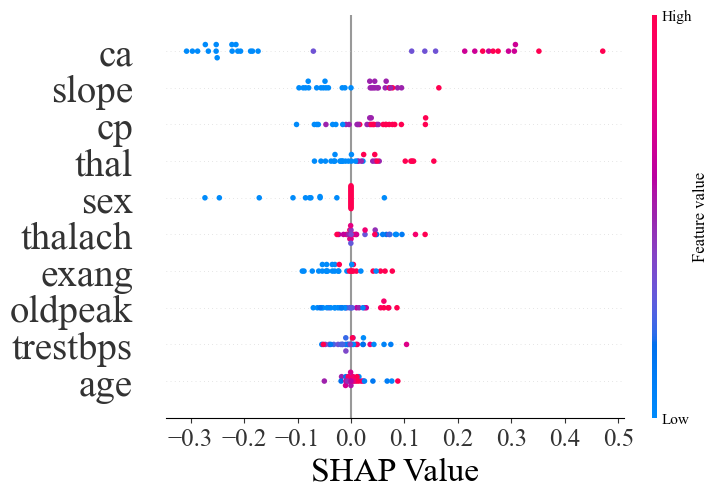

In [117]:
plt.rcParams.update({'font.family': 'Times New Roman'})

# Convert to DataFrame with correct feature names
X_B_train_df = pd.DataFrame(X_B_train, columns=feature_names)
X_B_test_df = pd.DataFrame(X_B_test, columns=feature_names)

# Define prediction function
def tabnet_predict(X):
    return tabnet_finetuned.predict_proba(X)[:, 1]

# Sample background data - increase size if possible
background = X_B_train_df.sample(n=2, random_state=42)

# Create explainer
explainer_tabnet = shap.KernelExplainer(tabnet_predict, background)

# Calculate SHAP values - start with fewer samples for testing
# test_sample = X_B_test_df.iloc[:2]  # Start with 20 samples
# shap_values_tabnet = explainer_tabnet.shap_values(test_sample)

# Uncomment this line to calculate SHAP values for the entire test dataset
shap_values_tabnet = explainer_tabnet.shap_values(X_B_test_df)  # Passing the entire test set

# Generate summary plot
plt.figure(figsize=(14, 8))
shap.summary_plot(shap_values_tabnet, X_B_test_df, max_display=20, show=False)

plt.xlabel('SHAP Value', fontsize=24)
plt.ylabel('', fontsize=26)


plt.xticks(fontsize=18, fontweight='normal')  # X-axis tick font size
plt.yticks(fontsize=28, fontweight='normal')  # Y-axis tick font size

plt.tight_layout()  # Adjust the layout to prevent clipping

# Save the plot as an image with high resolution and no caption
plt.savefig('shap_summary_tabnet.png', dpi=300, bbox_inches='tight')
plt.show()


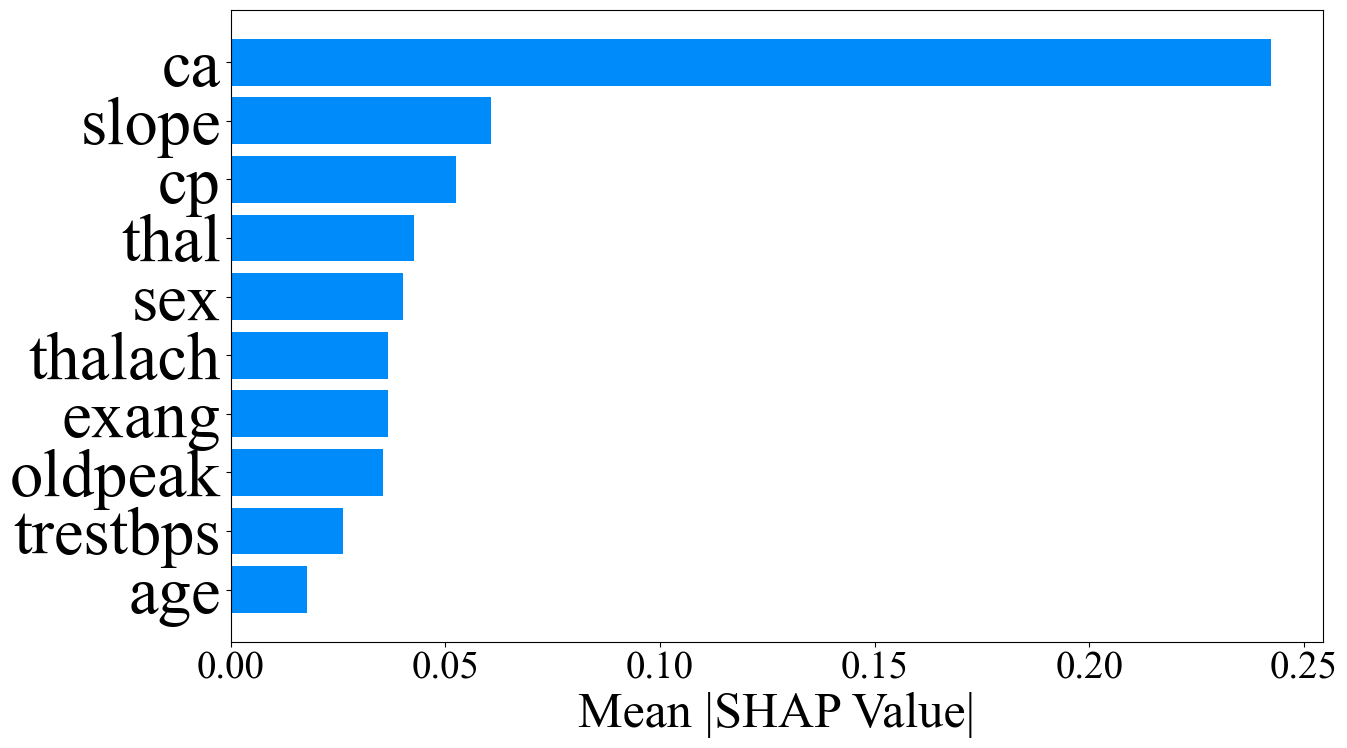

In [118]:
plt.rcParams.update({'font.family': 'Times New Roman'})


shap_values_abs = np.abs(shap_values_tabnet)
mean_shap_values = np.mean(shap_values_abs, axis=0)

# 2. DataFrame Creation (Fixed Naming)
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_shap_values
})

# 3. Sorting (Correct)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 4. Plotting (Fixed Reference)
plt.figure(figsize=(14, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#008bfb') 
plt.xlabel('Mean |SHAP Value|', fontweight='normal', fontsize = 36)
# plt.title('Feature Importance (TabNet)', fontsize=20, fontweight='bold')
plt.gca().invert_yaxis()


plt.xticks(fontsize=28, fontweight='normal')   # X-axis tick font size
plt.yticks(fontsize=48, fontweight='normal')  # Y-axis tick font size


plt.tight_layout()
plt.savefig('shap_feature_importance_tabnet.png', dpi=300, bbox_inches='tight')
plt.show()

### Confusion matrix and ROC-AUC curve for the proposed model(TabNet)

In [119]:
# Set global font to Times New Roman
plt.rcParams.update({'font.family': 'Times New Roman', 'font.weight': 'bold', 'font.size' : '16'})

cm = confusion_matrix(y_finetune_test, Dataset_B_Finetune)

# Unravel the confusion matrix to get TN, FP, FN, TP
tn, fp, fn, tp = cm.ravel()

# Create the plot with a specific size
plt.figure(figsize=(5, 4))

# Display confusion matrix as an image with the 'Blues' color map
im = plt.imshow(cm, cmap='Blues', interpolation='nearest')

# Set color bar ticks based on the max value of the matrix
vmax = cm.max()
colorbar_ticks = np.arange(0, vmax + 10, 10)
plt.colorbar(im, ticks=colorbar_ticks)

# Remove title as per request (You can uncomment the next line if you want to add a title)
# plt.title('Confusion Matrix of the fine-tuned model')

# Set X-axis labels (Predicted: Disease then No Disease)
plt.xticks([0, 1], ['No Disease', 'Disease']) 
plt.yticks([0, 1], ['No Disease', 'Disease']) 

# Label the axes
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Normalize the color range based on the confusion matrix values
norm = mcolors.Normalize(vmin=cm.min(), vmax=cm.max())
cmap = plt.colormaps['Blues']

# Iterate through the matrix to add text inside each cell
for i in range(2):
    for j in range(2):
        cell_value = cm[i, j]
        cell_color = cmap(norm(cell_value))  # Get the color of the cell based on the value
        luminance = 0.299 * cell_color[0] + 0.587 * cell_color[1] + 0.114 * cell_color[2]  # Calculate luminance
        text_color = 'white' if luminance < 0.5 else 'black'  # Choose white or black text based on luminance
        
        # Add the text inside the cell with bold and Times New Roman font
        plt.text(j, i, f'{cell_value}', ha='center', va='center', color=text_color, fontsize=24, fontweight='bold')

# Save the confusion matrix image with high resolution
plt.savefig('confusion_matrix_tabnet.png', dpi=300, bbox_inches='tight')
plt.close()

In [ ]:
# Ensure Times New Roman font is used in all plots
plt.rcParams.update({'font.family': 'Times New Roman', 'font.weight': 'bold', 'font.size' : '20'})

# Get predictions for TabNet model
y_pred = tabnet_finetuned.predict(X_B_test)  # Get the class predictions for target domain
y_pred_prob = tabnet_finetuned.predict_proba(X_B_test)[:, 1]  # Probabilities for the positive class (ROC)

# Calculate Precision, Recall, F1-Score
precision = precision_score(y_B_test, y_pred) * 100
recall = recall_score(y_B_test, y_pred) * 100
f1 = f1_score(y_B_test, y_pred) * 100

# Display the metrics
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1:.2f}%")

# Calculate Specificity: TN / (TN + FP)
tn, fp, fn, tp = confusion_matrix(y_B_test, y_pred).ravel()
specificity = (tn / (tn + fp)) * 100
print(f"Specificity: {specificity:.2f}%")

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_B_test, y_pred_prob) * 100
print(f"ROC-AUC: {roc_auc:.2f}%")

# Plot ROC curve with blue tones (IEEE standard)
fpr, tpr, _ = roc_curve(y_B_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(7, 6))

# Plot the ROC curve: Use 'orange' color and update the label
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', lw=2, linestyle='--')

# Set limits and labels as in the original image
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

# Adjust legend location to match the original image
plt.legend(loc='lower right', fontsize=18)

# Save the ROC curve image (you can keep your original filename or update it)
plt.savefig('roc_curve_tabnet.png', dpi=300, bbox_inches='tight')
plt.show()  # Display the plot



## 8. MLP

### Pretraining on the source domain

#### Hyperparameter tuning for pretraining stage

In [186]:
def build_model_for_tuning(hp):
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_l2_reg = hp.Choice('l2_reg', values=[0.01, 0.001, 0.0001])
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_neurons_l1 = hp.Int('neurons_l1', min_value=32, max_value=128, step=32)

    # input_dim = X_pretrain_train_res.shape[1]
    input_dim = X_A_train.shape[1]
    inputs = Input(shape=(input_dim,))

    # Layer 1 (Tuned Neurons, Tuned Dropout, Tuned L2)
    x = Dense(
        hp_neurons_l1, 
        activation='relu', 
        name='feature_layer_1',
        kernel_regularizer=keras.regularizers.l2(hp_l2_reg)
    )(inputs)
    x = Dropout(hp_dropout_rate)(x)

    # Layer 2 (Fixed at half of L1, or can be tuned as well)
    x = Dense(
        int(hp_neurons_l1 / 2), # e.g., 64 -> 32
        activation='relu', 
        name='feature_layer_2',
        kernel_regularizer=keras.regularizers.l2(hp_l2_reg)
    )(x)
    x = Dropout(hp_dropout_rate)(x)
    
    # Layer 3 (Fixed at quarter of L1, or can be tuned)
    x = Dense(
        int(hp_neurons_l1 / 4), # e.g., 64 -> 16
        activation='relu', 
        name='feature_layer_3',
        kernel_regularizer=keras.regularizers.l2(hp_l2_reg)
    )(x)
    x = Dropout(hp_dropout_rate)(x)
    
    # Output Layer
    outputs = Dense(1, activation='sigmoid', name='output_layer')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')] 
    )
    return model

In [187]:
print(X_pretrain_val.shape)
print(X_pretrain_train_res.shape)  # should match input layer


(61, 10)
(590, 10)


In [188]:
tuner = kt.RandomSearch(
    build_model_for_tuning,
    objective='auc',  # Metric to MAXIMIZE during tuning
    max_trials=30,        # Number of different models/hyperparameter combos to test
    executions_per_trial=3, # Number of times to train each model to reduce randomness
    directory='mlp_tuning', 
    project_name='heart_disease_pretrain'
)

# Optional: Print the search space
tuner.search_space_summary()

# Run the search
tuner.search(
    # X_pretrain_train_res, 
    # y_pretrain_train_res,
    X_A_train, 
    y_A_train,
    epochs=80, 
    validation_data=(X_A_val, y_A_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ],
    verbose=1
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n--- Optimal Hyperparameters ---")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"L2 Reg: {best_hps.get('l2_reg')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Neurons L1: {best_hps.get('neurons_l1')}")

# Retrieve the best model found
best_model = tuner.get_best_models(num_models=1)[0]

Search space summary
Default search space size: 4
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
l2_reg (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
neurons_l1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.0001            |0.0001            |learning_rate
0.0001            |0.0001            |l2_reg
0.1               |0.1               |dropout_rate
64                |64                |neurons_l1

Epoch 1/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.5085 - auc: 0.4290 - loss: 0.7855 - val_accuracy: 0.3934 - val_auc: 0.3953 - val_loss: 0.8545
Epoch 2/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - 

KeyboardInterrupt: 

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

best_params = best_hp.get_config()['values']

print("--- Best Hyperparameters ---")
for param, value in best_params.items():
    print(f"{param}: {value}")

### Pretraining on the source domain

In [191]:
#DO NOT RUN THIS LINE IF YOU DO THE HYPERPARAMETER TUNING
best_params = {
    'learning_rate' : 0.01,
    'l2_reg' : 0.0001,
    'neurons_l1' : 96,
    'dropout_rate' : 0.1
}

In [192]:
def create_mlp_model(input_shape, best_params):
    neurons_l1 = best_params['neurons_l1']
    dropout_rate = best_params['dropout_rate']
    l2_reg = best_params['l2_reg']
    learning_rate = best_params['learning_rate']

    inputs = Input(shape=(input_shape,))
    x = Dense(neurons_l1, activation='relu', name='feature_layer_1', kernel_regularizer=keras.regularizers.l2(l2_reg))(inputs)
    x = Dropout(dropout_rate)(x)
    
    x = Dense(int(neurons_l1/2), activation='relu', name='feature_layer_2', kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    
    x = Dense(int(neurons_l1/4), activation='relu', name='feature_layer_3', kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    
    outputs = Dense(1, activation='sigmoid', name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    return model

# input_dim = X_pretrain_train_res.shape[1]
input_dim = X_A_train.shape[1]
mlp_pretrain = create_mlp_model(input_dim, best_params)
mlp_pretrain.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer_1 (Dense)              │ (None, 96)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer_2 (Dense)              │ (None, 48)                  │           4,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer_3 (Dense)              │ (None, 24)                  │           1,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,913 (27.00 KB)

 Trainable params: 6,913 (27.00 KB)

 Non-trainable params: 0 (0.00 B)

In [193]:
pretrain_history = mlp_pretrain.fit(
    # X_pretrain_train_res, 
    # y_pretrain_train_res,
    X_A_train, 
    y_A_train,
    epochs=150, # Start with a reasonable number of epochs
    batch_size=32,
    # validation_data=(X_pretrain_val, y_pretrain_val),
    validation_data=(X_A_val, y_A_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=52, restore_best_weights=True)
    ],
    shuffle=False,
    verbose=1
)

# Save the pre-trained weights using the required extension
mlp_pretrain.save_weights('mlp_pretrain.weights.h5')

Epoch 1/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8169 - auc: 0.8983 - loss: 0.4301 - val_accuracy: 0.8197 - val_auc: 0.9015 - val_loss: 0.4304
Epoch 2/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8695 - auc: 0.9445 - loss: 0.3166 - val_accuracy: 0.8197 - val_auc: 0.9093 - val_loss: 0.3901
Epoch 3/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8864 - auc: 0.9535 - loss: 0.2896 - val_accuracy: 0.8197 - val_auc: 0.9144 - val_loss: 0.3686
Epoch 4/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8763 - auc: 0.9524 - loss: 0.2937 - val_accuracy: 0.8361 - val_auc: 0.9139 - val_loss: 0.3602
Epoch 5/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8966 - auc: 0.9643 - loss: 0.2605 - val_accuracy: 0.8525 - val_auc: 0.9212 - val_loss: 0.3783
Epoch 6/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9153 - auc: 0.9635 - loss: 0.2636 - val_accuracy: 0.8197 - val_auc: 0.9122 - val_loss: 0.3525
Epoch 7/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0

In [194]:
# Use the fine-tune validation set (X_finetune_val) to find the threshold
y_val_proba = mlp_pretrain.predict(X_B_val).ravel()
precision, recall, thresholds = precision_recall_curve(y_B_val, y_val_proba)

# Calculate F1 score for all thresholds
fscore = (2 * precision * recall) / (precision + recall + 1e-6) # Added 1e-6 to prevent division by zero
# Find the threshold that yields the maximum F1 score
ix = np.argmax(fscore)
best_threshold = thresholds[ix]

print(f"Optimal Threshold (Max F1 on Validation): {best_threshold:.4f}")
print(f"Max F1 Score at this threshold: {fscore[ix]:.4f}")

# Now, use best_threshold instead of 0.5 for final testing (e.g., y_pred = (y_pred_proba > best_threshold).astype(int))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Optimal Threshold (Max F1 on Validation): 0.8873
Max F1 Score at this threshold: 1.0000


In [195]:
print("\n--- Testing Pre-trained MLP on Dataset A (Source Domain) ---")

y_pred_proba_a = mlp_pretrain.predict(X_A_test).ravel()


# y_pred_a = (y_pred_proba_a > best_threshold).astype(int)

y_pred_a = (y_pred_proba_a > 0.5).astype(int)


# Calculate Metrics
accuracy_a = accuracy_score(y_A_test, y_pred_a) * 100
f1_a = f1_score(y_A_test, y_pred_a) * 100
roc_auc_a = roc_auc_score(y_A_test, y_pred_proba_a) * 100
recall_a = recall_score(y_A_test, y_pred_a) * 100
precision_a = precision_score(y_A_test, y_pred_a) * 100
specificity_a = recall_score(y_A_test, y_pred_a, pos_label=0) * 100

# Print the metrics
print(f"Pretraining Test Accuracy on Source domain: {accuracy_a:.2f}%")
print(f"Pretraining Test F1 on Source domain: {f1_a:.2f}%")
print(f"Pretraining Test Recall (Sensitivity) on Source domain: {recall_a:.2f}%")
print(f"Pretraining Test Specificity on Source domain: {specificity_a:.2f}%")
print(f"Pretraining Test ROC-AUC on Source domain: {roc_auc_score(y_pretrain_test, y_pred_proba_a):.2f}%")


--- Testing Pre-trained MLP on Dataset A (Source Domain) ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step 
Pretraining Test Accuracy on Source domain: 80.65%
Pretraining Test F1 on Source domain: 84.21%
Pretraining Test Recall (Sensitivity) on Source domain: 86.49%
Pretraining Test Specificity on Source domain: 72.00%
Pretraining Test ROC-AUC on Source domain: 0.91%


In [196]:
print("\n--- Testing Pre-trained MLP on Dataset B (Zero-Shot Transfer) ---")

# Get raw probability predictions
y_pred_proba_b = mlp_pretrain.predict(X_B_test).ravel()

# Convert probabilities to binary class predictions
# y_pred_b = (y_pred_proba_b > best_threshold).astype(int)

y_pred_b = (y_pred_proba_b > 0.5).astype(int)


# Calculate Metrics
accuracy_b = accuracy_score(y_B_test, y_pred_b) * 100
f1_b = f1_score(y_B_test, y_pred_b) * 100
roc_auc_b = roc_auc_score(y_B_test, y_pred_proba_b) * 100
recall_b = recall_score(y_B_test, y_pred_b) * 100
precision_b = precision_score(y_B_test, y_pred_b) * 100
specificity_b = recall_score(y_B_test, y_pred_b, pos_label=0) * 100

print(f"Pretraining Test Accuracy on target domain: {accuracy_b:.2f}%")
print(f"Pretraining Test F1 on target domain: {f1_b:.2f}%")
print(f"Pretraining Test Recall (Sensitivity) on target domain: {recall_b:.2f}%")
print(f"Pretraining Test Specificity on target domain: {specificity_b:.2f}%")
print(f"Pretraining Test ROC-AUC on target domain: {roc_auc_score(y_finetune_test, y_pred_proba_b):.2f}%")


--- Testing Pre-trained MLP on Dataset B (Zero-Shot Transfer) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Pretraining Test Accuracy on target domain: 77.42%
Pretraining Test F1 on target domain: 78.79%
Pretraining Test Recall (Sensitivity) on target domain: 92.86%
Pretraining Test Specificity on target domain: 64.71%
Pretraining Test ROC-AUC on target domain: 0.81%


### Finetuning on the target domain

In [197]:
def setup_fine_tuning(input_shape, pretrain_weights_path, best_params, fine_tune_lr=1e-1):
    # Create the model with exactly the same architecture as pre-training
    model_ft = create_mlp_model(input_shape, best_params)
    
    # Load pre-trained weights
    model_ft.load_weights(pretrain_weights_path)

    # Freeze layers for fine-tuning
    model_ft.get_layer('feature_layer_1').trainable = False
    model_ft.get_layer('feature_layer_2').trainable = True
    model_ft.get_layer('feature_layer_3').trainable = True
    
    # Recompile with lower learning rate for fine-tuning
    model_ft.compile(
        optimizer=Adam(learning_rate=fine_tune_lr),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]

    )
    
    finetune_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    
    return model_ft, finetune_scheduler


mlp_finetune, finetune_scheduler = setup_fine_tuning(
    input_shape=input_dim,  # Use the input dimension from Dataset B
    pretrain_weights_path='mlp_pretrain.weights.h5', 
    best_params=best_params,  # Add best_trial here
    fine_tune_lr=0.05
)



# Save the fine-tuned model weights (optional)
mlp_finetune.save_weights('mlp_finetune_weights.weights.h5')

# Check the model summary to ensure layers are frozen correctly
mlp_finetune.summary()


C:\Users\prosp\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer_1 (Dense)              │ (None, 96)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer_2 (Dense)              │ (None, 48)                  │           4,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer_3 (Dense)              │ (None, 24)                  │           1,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,913 (27.00 KB)

 Trainable params: 5,857 (22.88 KB)

 Non-trainable params: 1,056 (4.12 KB)

In [198]:
history_finetune = mlp_finetune.fit(
    # X_finetune_train_res, 
    # y_finetune_train_res,
    X_B_train, 
    y_B_train,
    epochs=300, # Fewer epochs are usually needed for fine-tuning
    batch_size=16, # Smaller batch size often works better for smaller datasets
    validation_data=(X_B_val, y_B_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True), 
    ],
    shuffle=False,
    verbose=1
)

print("Fine-tuning complete. The 'mlp_finetune' model is your final transfer model.")

Epoch 1/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.7443 - auc: 0.8284 - loss: 0.6419 - val_accuracy: 0.8667 - val_auc: 1.0000 - val_loss: 0.3461
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7977 - auc: 0.8402 - loss: 0.5432 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.2494
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8244 - auc: 0.8842 - loss: 0.4784 - val_accuracy: 0.9667 - val_auc: 0.9955 - val_loss: 0.2445
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8053 - auc: 0.8726 - loss: 0.4702 - val_accuracy: 0.9333 - val_auc: 0.9955 - val_loss: 0.2504
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8435 - auc: 0.9003 - loss: 0.4517 - val_accuracy: 0.9333 - val_auc: 0.9777 - val_loss: 0.2944
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8282 - auc: 0.9114 - loss: 0.4077 - val_accuracy: 0.9333 - val_auc: 0.9866 - val_loss: 0.2594
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 

In [199]:
# --- 1. Use the fine-tune validation set (X_finetune_val) to find the optimal threshold ---
y_val_proba_ft = mlp_finetune.predict(X_B_val).ravel()  # Raw probability predictions

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_B_val, y_val_proba_ft)

# Calculate F1 score for all thresholds
fscore = (2 * precision * recall) / (precision + recall + 1e-6)  # Adding 1e-6 to prevent division by zero

# Find the threshold that yields the maximum F1 score
ix = np.argmax(fscore)
best_finetune_threshold = thresholds[ix]

print(f"Optimal Threshold (Max F1 on Validation): {best_finetune_threshold:.4f}")
print(f"Max F1 Score at this threshold: {fscore[ix]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Optimal Threshold (Max F1 on Validation): 0.3553
Max F1 Score at this threshold: 0.9655


In [200]:
# Get raw probability predictions
y_pred_proba_a_ft = mlp_finetune.predict(X_A_test).ravel()

# Convert probabilities to binary class predictions
y_pred_a_ft = (y_pred_proba_a_ft > best_finetune_threshold).astype(int)

# Calculate Metrics
accuracy_a_ft = accuracy_score(y_A_test, y_pred_a_ft) * 100
f1_a_ft = f1_score(y_A_test, y_pred_a_ft) * 100
roc_auc_a_ft = roc_auc_score(y_A_test, y_pred_proba_a_ft) * 100
recall_a_ft = recall_score(y_A_test, y_pred_a_ft) * 100
precision_a_ft = precision_score(y_A_test, y_pred_a_ft) * 100
specificity_a_ft = recall_score(y_A_test, y_pred_a_ft, pos_label=0) * 100

print(f"Finetune Test Accuracy on source domain: {accuracy_a_ft:.2f}%")
print(f"Finetune Test F1 on source domain: {f1_a_ft:.2f}%")
print(f"Finetune Test Recall (Sensitivity) on source domain: {recall_a_ft:.2f}%")
print(f"Finetune Test Specificity on source domain: {specificity_a_ft:.2f}%")
print(f"Finetune Test ROC-AUC on source domain: {roc_auc_score(y_pretrain_test, y_pred_proba_a_ft):.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step 
Finetune Test Accuracy on source domain: 74.19%
Finetune Test F1 on source domain: 77.14%
Finetune Test Recall (Sensitivity) on source domain: 72.97%
Finetune Test Specificity on source domain: 76.00%
Finetune Test ROC-AUC on source domain: 0.83%


In [201]:
y_pred_proba_b_ft = mlp_finetune.predict(X_B_test).ravel()

# Convert probabilities to binary class predictions using a 0.5 threshold
y_pred_b_ft = (y_pred_proba_b_ft > best_finetune_threshold).astype(int)

# Calculate Metrics
accuracy_b_ft = accuracy_score(y_B_test, y_pred_b_ft) * 100
f1_b_ft = f1_score(y_B_test, y_pred_b_ft) * 100
roc_auc_b_ft = roc_auc_score(y_B_test, y_pred_proba_b_ft) * 100
recall_b_ft = recall_score(y_B_test, y_pred_b_ft) * 100
precision_b_ft = precision_score(y_B_test, y_pred_b_ft) * 100
specificity_b_ft = recall_score(y_B_test, y_pred_b_ft, pos_label=0) * 100


print(f"Finetune Test Accuracy on target domain: {accuracy_b_ft:.2f}%")
print(f"Finetune Test F1 on target domain: {f1_b_ft:.2f}%")
print(f"Finetune Test Recall (Sensitivity) on target domain: {recall_b_ft:.2f}%")
print(f"Finetune Test Specificity on target domain: {specificity_b_ft:.2f}%")
print(f"Finetune Test ROC-AUC on target domain:{roc_auc_score(y_finetune_test, y_pred_proba_b_ft):.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Finetune Test Accuracy on target domain: 77.42%
Finetune Test F1 on target domain: 77.42%
Finetune Test Recall (Sensitivity) on target domain: 85.71%
Finetune Test Specificity on target domain: 70.59%
Finetune Test ROC-AUC on target domain:0.90%


### SHAP figure from the proposed model

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  0%|          | 0/31 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━

C:\Users\prosp\AppData\Local\Temp\ipykernel_19640\3557193094.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_mlp, X_finetune_test, max_display=20, show=False)


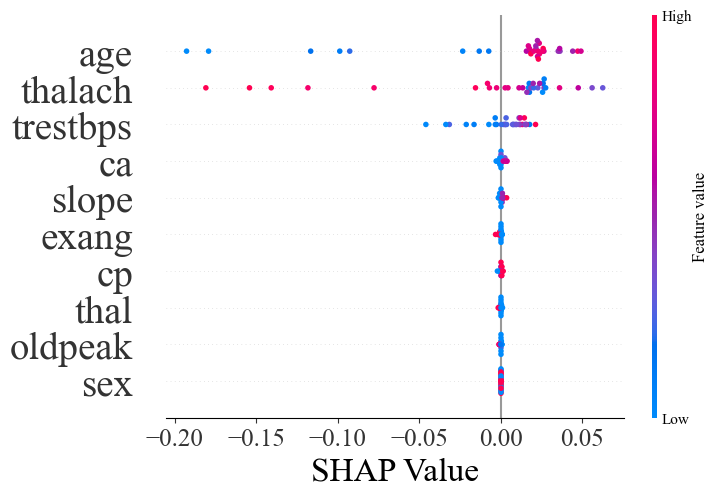

In [202]:
plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 24})  # Set global font size

def mlp_predict(X):
    return mlp_finetune.predict(X)[:, 0]  # We are interested in the probability for class 1

# Select a sample from the training data (background dataset) for SHAP
background = X_finetune_train.sample(n=100, random_state=42)

# Create the SHAP explainer
explainer_mlp = shap.KernelExplainer(mlp_predict, background)

# Calculate SHAP values for the full test set
shap_values_mlp = explainer_mlp.shap_values(X_finetune_test)  # Use the full test set

plt.figure(figsize=(14, 8))
shap.summary_plot(shap_values_mlp, X_finetune_test, max_display=20, show=False)

# Customize title, axis labels, and ticks
plt.xlabel('SHAP Value', fontsize=24, fontweight='normal')  # X-axis font size
plt.ylabel('', fontsize=26, fontweight='normal')  # Y-axis font size

# Increase font size for tick labels
plt.xticks(fontsize=18, fontweight='normal')  # X-axis tick font size
plt.yticks(fontsize=28, fontweight='normal')  # Y-axis tick font size

plt.tight_layout()  # Adjust the layout to prevent clipping

plt.savefig('shap_summary_mlp.png', dpi=300, bbox_inches='tight')
plt.show()


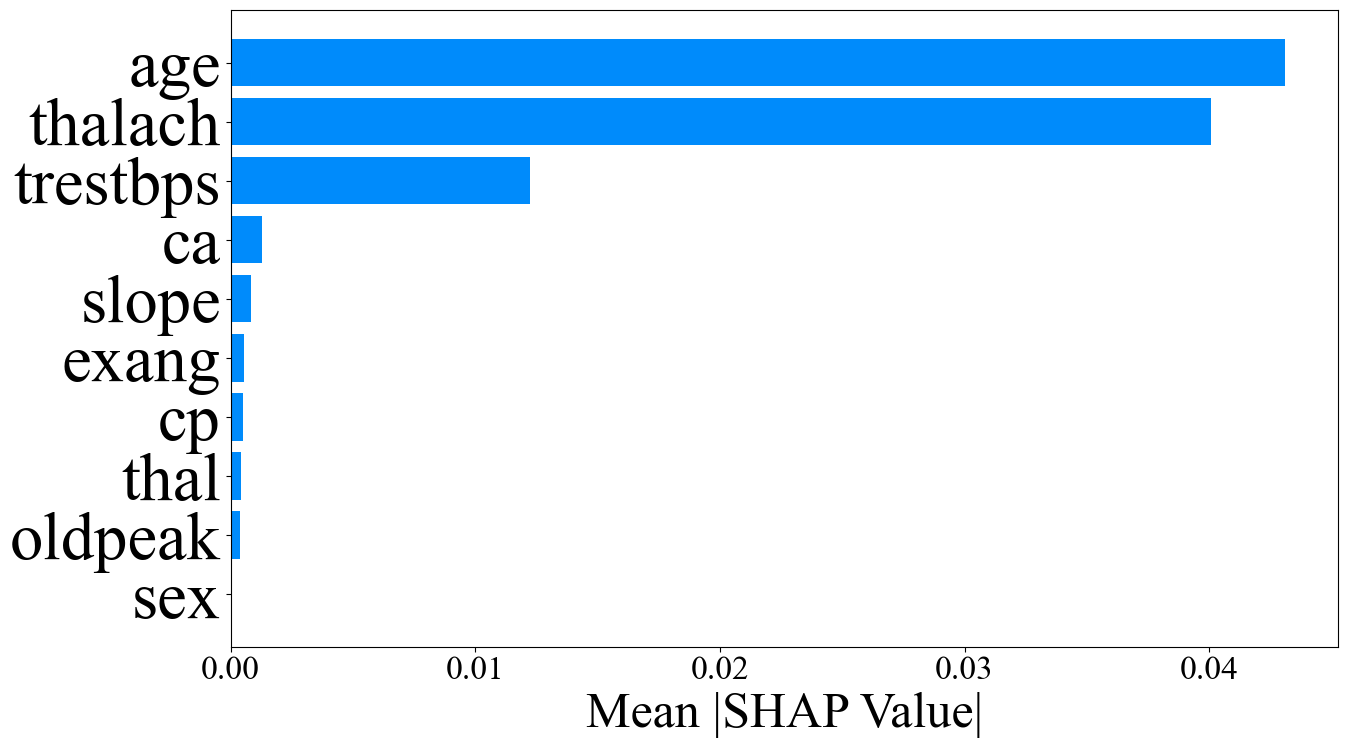

In [203]:
# Calculate the absolute SHAP values
shap_values_abs_mlp = np.abs(shap_values_mlp)  # Take absolute values of SHAP values

# Calculate the mean SHAP value for each feature
mean_shap_values_mlp = np.mean(shap_values_abs_mlp, axis=0)  # Mean across all samples for each feature

# Create a DataFrame to store feature importance
feature_importance_mlp_df = pd.DataFrame({
    'Feature': X_finetune_test.columns,  # feature names
    'Mean SHAP Value': mean_shap_values_mlp
})

# Sort the DataFrame by the importance of features (descending order)
feature_importance_mlp_df = feature_importance_mlp_df.sort_values(by='Mean SHAP Value', ascending=False)

# Plot feature importance
plt.figure(figsize=(14, 8))
plt.barh(feature_importance_mlp_df['Feature'], feature_importance_mlp_df['Mean SHAP Value'], color='#008bfb')
plt.xlabel('Mean |SHAP Value|', fontweight='normal', fontsize = 36)

plt.xticks(fontsize=24, fontweight='normal')   # X-axis tick font size
plt.yticks(fontsize=48, fontweight='normal')  # Y-axis tick font size



plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
plt.tight_layout()  # Ensure the layout is tight
plt.savefig('shap_feature_importance_mlp.png', dpi=300, bbox_inches='tight')
plt.show()


### Confusion matrix and ROC-AUC curve for the proposed model

In [ ]:
plt.rcParams.update({'font.family': 'Times New Roman', 'font.weight': 'bold', 'font.size' : '16'})

# Confusion matrix
cm_mlp = confusion_matrix(y_finetune_test, y_pred_b_ft)
# Unravel the confusion matrix to get TN, FP, FN, TP
tn, fp, fn, tp = cm_mlp.ravel()

plt.figure(figsize=(5, 4))
im = plt.imshow(cm_mlp, cmap='Blues', interpolation='nearest') 

vmax = cm_mlp.max()
colorbar_ticks = np.arange(0, vmax + 10, 10)
plt.colorbar(im, ticks=colorbar_ticks)

ax = plt.gca()

# Set X-axis labels (Predicted: Disease then No Disease)
plt.xticks([0, 1], ['Disease', 'No Disease'])
# Set Y-axis labels (Actual: Disease then No Disease)
plt.yticks([0, 1], ['No Disease', 'Disease'], rotation=90)  # Horizontal labels

plt.ylabel('Actual')
plt.xlabel('Predicted')

# Dynamic text color for contrast
norm = mcolors.Normalize(vmin=cm_mlp.min(), vmax=cm_mlp.max())
cmap = plt.colormaps['Blues']

for i in range(2):
    for j in range(2):
        cell_value = cm_mlp[i, j]
        cell_color = cmap(norm(cell_value))
        luminance = 0.299 * cell_color[0] + 0.587 * cell_color[1] + 0.114 * cell_color[2]
        text_color = 'white' if luminance < 0.5 else 'black'
        
        plt.text(j, i, f'{cell_value}', ha='center', va='center', color=text_color, fontsize=24, fontweight='bold')

# Save the confusion matrix image
plt.savefig('confusion_matrix_mlp.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## 9. Combined models ROC-AUC curve and Decision Curve Analysis

In [125]:
y_pred_prob_mlp = mlp_finetune.predict(X_finetune_test).ravel()
y_pred_prob_tabnet = tabnet_finetuned.predict_proba(X_B_test)[:, 1]
y_pred_prob_xgb = xgb_finetune.predict_proba(X_finetune_test)[:, 1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
MLP AUC (auc function): 0.8908
MLP AUC (roc_auc_score): 0.8908
TabNet AUC: 0.7164
XGBoost AUC: 0.8529


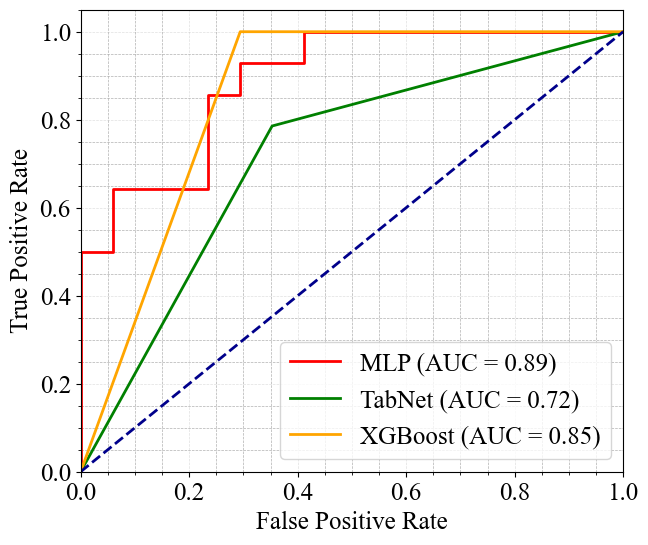

In [126]:
plt.rcParams.update({'font.family': 'Times New Roman', 'font.weight': 'normal', 'font.size': 18})

# Get predicted probabilities for each model
y_pred_prob_mlp = mlp_finetune.predict(X_finetune_test)
y_pred_prob_tabnet = tabnet_finetuned.predict(X_B_test)  # Probabilities for the positive class (ROC)
y_pred_proba_xgb = xgb_finetune.predict(X_finetune_test) 

# Calculate ROC curve and AUC for each model
fpr_mlp, tpr_mlp, _ = roc_curve(y_finetune_test, y_pred_prob_mlp)
fpr_tabnet, tpr_tabnet, _ = roc_curve(y_B_test, y_pred_prob_tabnet)
fpr_xgb, tpr_xgb, _ = roc_curve(y_finetune_test, Dataset_B_Finetune)

# Calculate AUC for each model
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
roc_auc_tabnet = auc(fpr_tabnet, tpr_tabnet)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# fpr, tpr, _ = roc_curve(y_finetune_test, Dataset_B_Finetune)

# Also calculate using roc_auc_score for verification
roc_auc_score_mlp = roc_auc_score(y_B_test, y_pred_prob_mlp)
roc_auc_score_tabnet = roc_auc_score(y_B_test, y_pred_prob_tabnet)
roc_auc_score_xgb = roc_auc_score(y_B_test, y_pred_proba_xgb)

print(f"MLP AUC (auc function): {roc_auc_mlp:.4f}")
print(f"MLP AUC (roc_auc_score): {roc_auc_score_mlp:.4f}")
print(f"TabNet AUC: {roc_auc_tabnet:.4f}")
print(f"XGBoost AUC: {roc_auc_xgb:.4f}")

# Plot combined ROC curve
plt.figure(figsize=(7, 6))

# Plot each ROC curve
plt.plot(fpr_mlp, tpr_mlp, color='red', lw=2, label=f'MLP (AUC = {roc_auc_mlp:.2f})')
plt.plot(fpr_tabnet, tpr_tabnet, color='green', lw=2, label=f'TabNet (AUC = {roc_auc_tabnet:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='orange', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='darkblue', lw=2, linestyle='--')

# Enable minor ticks for more grid lines
plt.minorticks_on()

# Customize grid settings for major and minor grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=1)

# Adjust plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Combined ROC Curve for Fine-Tuned Models')
plt.legend(loc='lower right')

# Add grid for better readability
plt.grid(True, alpha=0.4)


# Save the combined ROC curve
plt.savefig('roc_curve_combined.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()
plt.close()


In [167]:
def decision_curve_analysis(y_true, y_prob, thresholds):
    """
    Compute net benefit for Decision Curve Analysis (DCA)

    Parameters:
        y_true (array-like): True binary labels (0 or 1)
        y_prob (array-like): Predicted probabilities
        thresholds (array-like): Threshold probabilities

    Returns:
        net_benefit (np.ndarray)
    """
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)

    N = len(y_true)
    net_benefit = []

    for pt in thresholds:
        y_pred = (y_prob >= pt).astype(int)

        TP = np.sum((y_pred == 1) & (y_true == 1))
        FP = np.sum((y_pred == 1) & (y_true == 0))

        nb = (TP / N) - (FP / N) * (pt / (1 - pt))
        net_benefit.append(nb)

    return np.array(net_benefit)


In [168]:
# MLP
y_prob_mlp = mlp_finetune.predict(X_finetune_test).ravel()
# TabNet
y_prob_tabnet = tabnet_finetuned.predict_proba(X_B_test)[:, 1]
# XGBoost
y_prob_xgb = xgb_finetune.predict_proba(X_finetune_test)[:, 1]
# Ground truth
y_true = y_finetune_test.values

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


In [169]:
def treat_all_net_benefit(y_true, thresholds):
    prevalence = np.mean(y_true)
    return prevalence - (1 - prevalence) * (thresholds / (1 - thresholds))

def treat_none_net_benefit(thresholds):
    return np.zeros_like(thresholds)

In [170]:
thresholds = np.linspace(0.01, 0.99, 99)

In [171]:
nb_mlp = decision_curve_analysis(y_true, y_prob_mlp, thresholds)
nb_tabnet = decision_curve_analysis(y_true, y_prob_tabnet, thresholds)
nb_xgb = decision_curve_analysis(y_true, y_prob_xgb, thresholds)

nb_all = treat_all_net_benefit(y_true, thresholds)
nb_none = treat_none_net_benefit(thresholds)

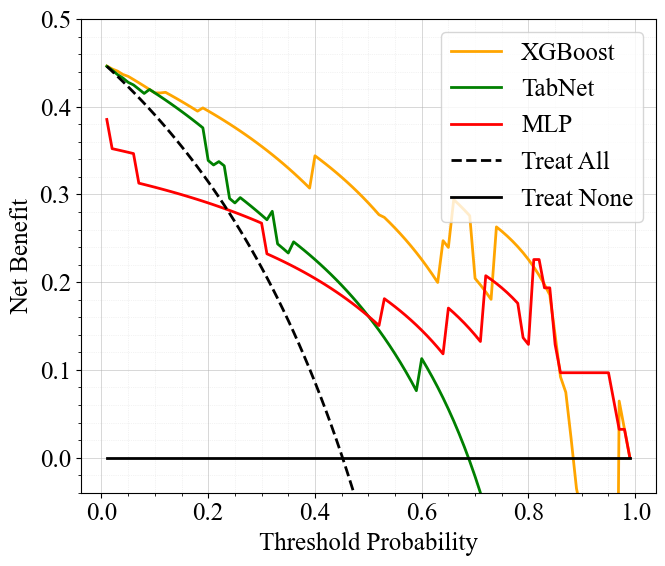

In [184]:
plt.rcParams.update({'font.family': 'Times New Roman', 'font.weight': 'normal', 'font.size': 18})

plt.figure(figsize=(7, 6))

# Plot net benefit curves
plt.plot(thresholds, nb_xgb, label=f'XGBoost', color='orange', linewidth=2)
plt.plot(thresholds, nb_tabnet, label=f'TabNet', color='green', linewidth=2)
plt.plot(thresholds, nb_mlp, label=f'MLP', color='red', linewidth=2)

# Plot treat-all and treat-none lines
plt.plot(thresholds, nb_all, linestyle='--', color='black', label='Treat All', linewidth=2)
plt.plot(thresholds, nb_none, linestyle='-', color='black', label='Treat None', linewidth=2)

# Axes labels
plt.xlabel('Threshold Probability')
plt.ylabel('Net Benefit')

plt.ylim(-0.04, 0.5)

# Minor ticks for more grid lines
plt.minorticks_on()

# Major and minor grid
plt.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.5)
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.3)

# Legend
plt.legend(loc='upper right')

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig('dca_combined.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()